# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

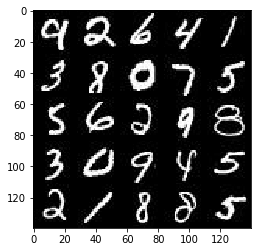

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

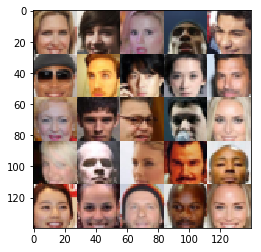

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'inputs')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z_input')
    learning_rate = tf.placeholder(tf.float32, None, 'learning_rate')

    return inputs, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kernel_size = 5

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #no batch norm on first layer
        relu1 = tf.nn.leaky_relu(x1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)

        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, kernel_size, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.leaky_relu(bn2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, kernel_size, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.leaky_relu(bn3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernel_size = 5
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.leaky_relu(x1)
        # 7x7x512 now

        #stride one!
#         x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.leaky_relu(x2)
        x2 = tf.layers.dropout(x2, rate=0.5)
        # 14x14x256

        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size, strides=2, padding='same')
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.leaky_relu(x3)
        x3 = tf.layers.dropout(x3, rate=0.5)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    z_size = z_dim

    class Gan:
        def __init__(self, real_size, z_size, beta1=0.5):
            self.input_real, self.input_z, self.learning_rate = model_inputs(real_size[0], real_size[1], real_size[2], z_size)
            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2])
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)
        
    net = Gan((data_shape[1], data_shape[2], data_shape[3]), z_size, beta1)
    out_channel_dim = data_shape[3]
    
    steps = 0
    print_every=10
    show_every=100
    n_images = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #rescale to -1 to +1
                batch_images = 2 * batch_images
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Step {} ".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, net.input_z, out_channel_dim, data_image_mode)


#         saver.save(sess, './checkpoints/generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10  Discriminator Loss: 0.4359... Generator Loss: 8.9153
Epoch 1/2... Step 20  Discriminator Loss: 1.5683... Generator Loss: 13.5649
Epoch 1/2... Step 30  Discriminator Loss: 0.9370... Generator Loss: 2.3811
Epoch 1/2... Step 40  Discriminator Loss: 1.1752... Generator Loss: 1.3807
Epoch 1/2... Step 50  Discriminator Loss: 2.1538... Generator Loss: 0.3189
Epoch 1/2... Step 60  Discriminator Loss: 1.8827... Generator Loss: 0.2982
Epoch 1/2... Step 70  Discriminator Loss: 2.1415... Generator Loss: 0.2782
Epoch 1/2... Step 80  Discriminator Loss: 1.5650... Generator Loss: 0.5151
Epoch 1/2... Step 90  Discriminator Loss: 1.8919... Generator Loss: 0.3115
Epoch 1/2... Step 100  Discriminator Loss: 1.3860... Generator Loss: 0.5885


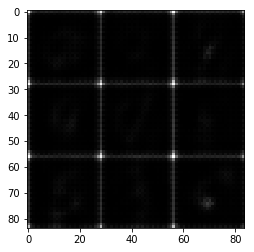

Epoch 1/2... Step 110  Discriminator Loss: 1.6857... Generator Loss: 0.3517
Epoch 1/2... Step 120  Discriminator Loss: 1.6237... Generator Loss: 0.4018
Epoch 1/2... Step 130  Discriminator Loss: 1.4877... Generator Loss: 1.2316
Epoch 1/2... Step 140  Discriminator Loss: 1.2949... Generator Loss: 1.0937
Epoch 1/2... Step 150  Discriminator Loss: 1.3670... Generator Loss: 1.0740
Epoch 1/2... Step 160  Discriminator Loss: 1.3760... Generator Loss: 0.6988
Epoch 1/2... Step 170  Discriminator Loss: 1.1862... Generator Loss: 1.3484
Epoch 1/2... Step 180  Discriminator Loss: 1.1329... Generator Loss: 1.4188
Epoch 1/2... Step 190  Discriminator Loss: 1.3361... Generator Loss: 0.9381
Epoch 1/2... Step 200  Discriminator Loss: 1.0363... Generator Loss: 1.8079


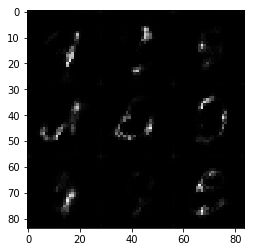

Epoch 1/2... Step 210  Discriminator Loss: 1.3653... Generator Loss: 0.8944
Epoch 1/2... Step 220  Discriminator Loss: 1.2052... Generator Loss: 1.7823
Epoch 1/2... Step 230  Discriminator Loss: 1.2436... Generator Loss: 1.1075
Epoch 1/2... Step 240  Discriminator Loss: 1.1568... Generator Loss: 1.7705
Epoch 1/2... Step 250  Discriminator Loss: 1.1981... Generator Loss: 0.8600
Epoch 1/2... Step 260  Discriminator Loss: 1.4622... Generator Loss: 2.0720
Epoch 1/2... Step 270  Discriminator Loss: 1.4354... Generator Loss: 0.7160
Epoch 1/2... Step 280  Discriminator Loss: 1.5044... Generator Loss: 0.4640
Epoch 1/2... Step 290  Discriminator Loss: 1.4756... Generator Loss: 0.4263
Epoch 1/2... Step 300  Discriminator Loss: 1.3137... Generator Loss: 0.6062


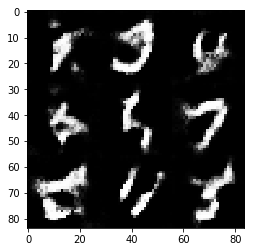

Epoch 1/2... Step 310  Discriminator Loss: 2.3480... Generator Loss: 3.1583
Epoch 1/2... Step 320  Discriminator Loss: 1.4974... Generator Loss: 0.5284
Epoch 1/2... Step 330  Discriminator Loss: 1.0901... Generator Loss: 0.8598
Epoch 1/2... Step 340  Discriminator Loss: 2.0478... Generator Loss: 0.2288
Epoch 1/2... Step 350  Discriminator Loss: 1.3465... Generator Loss: 0.9177
Epoch 1/2... Step 360  Discriminator Loss: 1.5377... Generator Loss: 0.4404
Epoch 1/2... Step 370  Discriminator Loss: 1.0031... Generator Loss: 1.3031
Epoch 1/2... Step 380  Discriminator Loss: 1.4341... Generator Loss: 0.9783
Epoch 1/2... Step 390  Discriminator Loss: 1.2930... Generator Loss: 0.9671
Epoch 1/2... Step 400  Discriminator Loss: 1.0157... Generator Loss: 1.3745


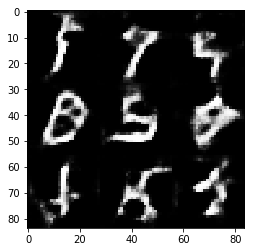

Epoch 1/2... Step 410  Discriminator Loss: 1.2528... Generator Loss: 0.8208
Epoch 1/2... Step 420  Discriminator Loss: 1.3291... Generator Loss: 1.0345
Epoch 1/2... Step 430  Discriminator Loss: 1.6161... Generator Loss: 0.3702
Epoch 1/2... Step 440  Discriminator Loss: 1.5686... Generator Loss: 0.3938
Epoch 1/2... Step 450  Discriminator Loss: 1.2886... Generator Loss: 1.2241
Epoch 1/2... Step 460  Discriminator Loss: 1.5260... Generator Loss: 0.4875
Epoch 1/2... Step 470  Discriminator Loss: 1.3586... Generator Loss: 0.5893
Epoch 1/2... Step 480  Discriminator Loss: 1.3242... Generator Loss: 0.6118
Epoch 1/2... Step 490  Discriminator Loss: 1.3280... Generator Loss: 0.5302
Epoch 1/2... Step 500  Discriminator Loss: 1.3018... Generator Loss: 0.6578


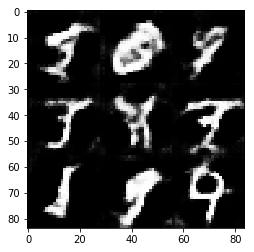

Epoch 1/2... Step 510  Discriminator Loss: 1.3408... Generator Loss: 0.6046
Epoch 1/2... Step 520  Discriminator Loss: 1.6902... Generator Loss: 0.3349
Epoch 1/2... Step 530  Discriminator Loss: 1.7183... Generator Loss: 0.3081
Epoch 1/2... Step 540  Discriminator Loss: 1.1675... Generator Loss: 1.0476
Epoch 1/2... Step 550  Discriminator Loss: 1.3244... Generator Loss: 0.6048
Epoch 1/2... Step 560  Discriminator Loss: 1.2367... Generator Loss: 1.5620
Epoch 1/2... Step 570  Discriminator Loss: 1.1513... Generator Loss: 0.9457
Epoch 1/2... Step 580  Discriminator Loss: 1.3407... Generator Loss: 1.3045
Epoch 1/2... Step 590  Discriminator Loss: 1.4644... Generator Loss: 0.4974
Epoch 1/2... Step 600  Discriminator Loss: 1.2539... Generator Loss: 0.7056


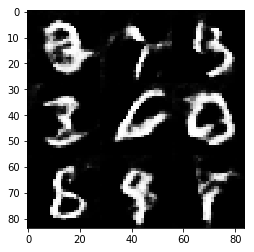

Epoch 1/2... Step 610  Discriminator Loss: 1.1884... Generator Loss: 0.7660
Epoch 1/2... Step 620  Discriminator Loss: 1.1819... Generator Loss: 0.6183
Epoch 1/2... Step 630  Discriminator Loss: 1.3786... Generator Loss: 0.8902
Epoch 1/2... Step 640  Discriminator Loss: 1.4741... Generator Loss: 0.4731
Epoch 1/2... Step 650  Discriminator Loss: 1.6754... Generator Loss: 0.3583
Epoch 1/2... Step 660  Discriminator Loss: 1.2558... Generator Loss: 1.0124
Epoch 1/2... Step 670  Discriminator Loss: 1.3740... Generator Loss: 1.0647
Epoch 1/2... Step 680  Discriminator Loss: 1.3122... Generator Loss: 0.6132
Epoch 1/2... Step 690  Discriminator Loss: 1.1721... Generator Loss: 0.7527
Epoch 1/2... Step 700  Discriminator Loss: 1.2876... Generator Loss: 1.5812


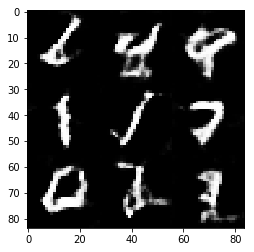

Epoch 1/2... Step 710  Discriminator Loss: 1.2223... Generator Loss: 0.9441
Epoch 1/2... Step 720  Discriminator Loss: 1.0481... Generator Loss: 1.1022
Epoch 1/2... Step 730  Discriminator Loss: 1.2480... Generator Loss: 1.2873
Epoch 1/2... Step 740  Discriminator Loss: 1.1981... Generator Loss: 0.6611
Epoch 1/2... Step 750  Discriminator Loss: 1.5948... Generator Loss: 0.3881
Epoch 1/2... Step 760  Discriminator Loss: 1.0389... Generator Loss: 1.0467
Epoch 1/2... Step 770  Discriminator Loss: 1.2720... Generator Loss: 0.6322
Epoch 1/2... Step 780  Discriminator Loss: 1.0094... Generator Loss: 1.3164
Epoch 1/2... Step 790  Discriminator Loss: 1.6985... Generator Loss: 0.3663
Epoch 1/2... Step 800  Discriminator Loss: 1.5289... Generator Loss: 0.4228


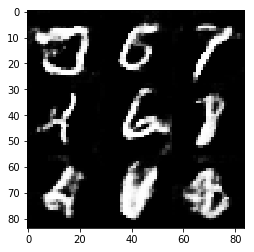

Epoch 1/2... Step 810  Discriminator Loss: 1.1850... Generator Loss: 1.1610
Epoch 1/2... Step 820  Discriminator Loss: 1.3927... Generator Loss: 0.9498
Epoch 1/2... Step 830  Discriminator Loss: 1.2389... Generator Loss: 0.6298
Epoch 1/2... Step 840  Discriminator Loss: 1.1391... Generator Loss: 1.1029
Epoch 1/2... Step 850  Discriminator Loss: 1.2141... Generator Loss: 0.9553
Epoch 1/2... Step 860  Discriminator Loss: 1.8219... Generator Loss: 0.2941
Epoch 1/2... Step 870  Discriminator Loss: 1.1855... Generator Loss: 0.7297
Epoch 1/2... Step 880  Discriminator Loss: 1.4652... Generator Loss: 0.4316
Epoch 1/2... Step 890  Discriminator Loss: 1.2392... Generator Loss: 1.0504
Epoch 1/2... Step 900  Discriminator Loss: 1.2003... Generator Loss: 1.1575


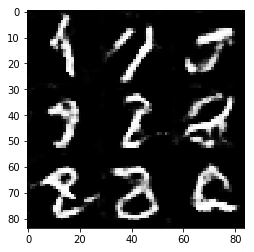

Epoch 1/2... Step 910  Discriminator Loss: 1.5898... Generator Loss: 0.4197
Epoch 1/2... Step 920  Discriminator Loss: 1.1566... Generator Loss: 0.7550
Epoch 1/2... Step 930  Discriminator Loss: 1.2885... Generator Loss: 0.5794
Epoch 1/2... Step 940  Discriminator Loss: 2.1586... Generator Loss: 0.2000
Epoch 1/2... Step 950  Discriminator Loss: 1.3874... Generator Loss: 0.5382
Epoch 1/2... Step 960  Discriminator Loss: 1.3971... Generator Loss: 0.7873
Epoch 1/2... Step 970  Discriminator Loss: 1.4580... Generator Loss: 1.4520
Epoch 1/2... Step 980  Discriminator Loss: 1.0338... Generator Loss: 0.9031
Epoch 1/2... Step 990  Discriminator Loss: 1.0976... Generator Loss: 0.8686
Epoch 1/2... Step 1000  Discriminator Loss: 1.3309... Generator Loss: 0.5478


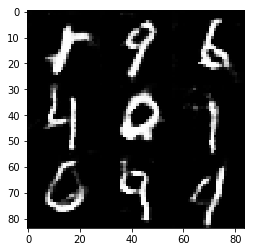

Epoch 1/2... Step 1010  Discriminator Loss: 1.5539... Generator Loss: 0.4104
Epoch 1/2... Step 1020  Discriminator Loss: 1.3652... Generator Loss: 0.5480
Epoch 1/2... Step 1030  Discriminator Loss: 1.4691... Generator Loss: 0.4929
Epoch 1/2... Step 1040  Discriminator Loss: 1.2296... Generator Loss: 0.6562
Epoch 1/2... Step 1050  Discriminator Loss: 1.2193... Generator Loss: 1.4795
Epoch 1/2... Step 1060  Discriminator Loss: 1.3487... Generator Loss: 1.5589
Epoch 1/2... Step 1070  Discriminator Loss: 0.9851... Generator Loss: 0.8827
Epoch 1/2... Step 1080  Discriminator Loss: 1.4753... Generator Loss: 0.4687
Epoch 1/2... Step 1090  Discriminator Loss: 1.2406... Generator Loss: 0.6459
Epoch 1/2... Step 1100  Discriminator Loss: 1.2383... Generator Loss: 2.0423


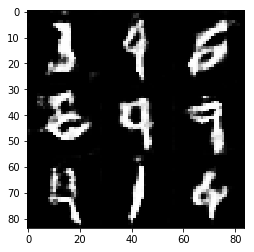

Epoch 1/2... Step 1110  Discriminator Loss: 1.4464... Generator Loss: 0.5032
Epoch 1/2... Step 1120  Discriminator Loss: 1.0172... Generator Loss: 1.3395
Epoch 1/2... Step 1130  Discriminator Loss: 1.0387... Generator Loss: 1.2961
Epoch 1/2... Step 1140  Discriminator Loss: 1.1763... Generator Loss: 0.6706
Epoch 1/2... Step 1150  Discriminator Loss: 1.4696... Generator Loss: 0.4834
Epoch 1/2... Step 1160  Discriminator Loss: 1.1624... Generator Loss: 1.1710
Epoch 1/2... Step 1170  Discriminator Loss: 1.0413... Generator Loss: 1.0325
Epoch 1/2... Step 1180  Discriminator Loss: 2.3701... Generator Loss: 0.1890
Epoch 1/2... Step 1190  Discriminator Loss: 1.1186... Generator Loss: 0.7347
Epoch 1/2... Step 1200  Discriminator Loss: 1.5322... Generator Loss: 0.4418


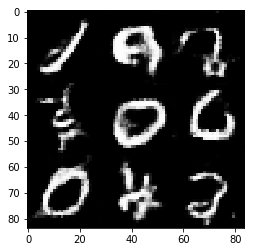

Epoch 1/2... Step 1210  Discriminator Loss: 1.1408... Generator Loss: 1.3549
Epoch 1/2... Step 1220  Discriminator Loss: 1.2735... Generator Loss: 0.8701
Epoch 1/2... Step 1230  Discriminator Loss: 1.0349... Generator Loss: 0.7931
Epoch 1/2... Step 1240  Discriminator Loss: 1.3238... Generator Loss: 0.5459
Epoch 1/2... Step 1250  Discriminator Loss: 1.3102... Generator Loss: 1.8640
Epoch 1/2... Step 1260  Discriminator Loss: 1.2056... Generator Loss: 0.7158
Epoch 1/2... Step 1270  Discriminator Loss: 1.2733... Generator Loss: 0.6193
Epoch 1/2... Step 1280  Discriminator Loss: 1.1078... Generator Loss: 1.3244
Epoch 1/2... Step 1290  Discriminator Loss: 1.2273... Generator Loss: 1.7111
Epoch 1/2... Step 1300  Discriminator Loss: 1.3061... Generator Loss: 0.6626


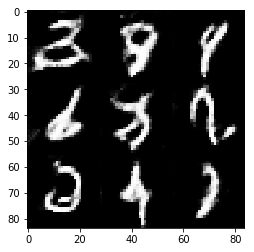

Epoch 1/2... Step 1310  Discriminator Loss: 1.0587... Generator Loss: 0.8285
Epoch 1/2... Step 1320  Discriminator Loss: 1.4590... Generator Loss: 0.4358
Epoch 1/2... Step 1330  Discriminator Loss: 1.1460... Generator Loss: 0.6472
Epoch 1/2... Step 1340  Discriminator Loss: 1.3786... Generator Loss: 1.8191
Epoch 1/2... Step 1350  Discriminator Loss: 1.0437... Generator Loss: 0.9199
Epoch 1/2... Step 1360  Discriminator Loss: 1.0763... Generator Loss: 2.0257
Epoch 1/2... Step 1370  Discriminator Loss: 1.1308... Generator Loss: 0.7671
Epoch 1/2... Step 1380  Discriminator Loss: 1.2533... Generator Loss: 0.7550
Epoch 1/2... Step 1390  Discriminator Loss: 1.0237... Generator Loss: 1.0446
Epoch 1/2... Step 1400  Discriminator Loss: 1.6259... Generator Loss: 0.3848


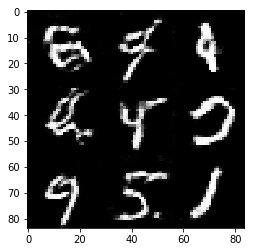

Epoch 1/2... Step 1410  Discriminator Loss: 0.9607... Generator Loss: 0.9646
Epoch 1/2... Step 1420  Discriminator Loss: 1.5654... Generator Loss: 0.4000
Epoch 1/2... Step 1430  Discriminator Loss: 1.8052... Generator Loss: 0.3048
Epoch 1/2... Step 1440  Discriminator Loss: 0.8204... Generator Loss: 1.2889
Epoch 1/2... Step 1450  Discriminator Loss: 1.1397... Generator Loss: 1.3954
Epoch 1/2... Step 1460  Discriminator Loss: 0.9828... Generator Loss: 1.3046
Epoch 1/2... Step 1470  Discriminator Loss: 0.8022... Generator Loss: 1.9180
Epoch 1/2... Step 1480  Discriminator Loss: 1.0116... Generator Loss: 1.3311
Epoch 1/2... Step 1490  Discriminator Loss: 0.8429... Generator Loss: 1.9613
Epoch 1/2... Step 1500  Discriminator Loss: 0.9703... Generator Loss: 1.0090


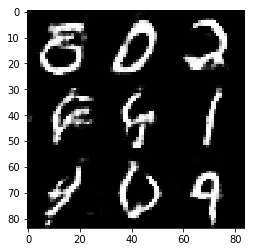

Epoch 1/2... Step 1510  Discriminator Loss: 1.4620... Generator Loss: 1.8439
Epoch 1/2... Step 1520  Discriminator Loss: 1.0918... Generator Loss: 0.7614
Epoch 1/2... Step 1530  Discriminator Loss: 1.1987... Generator Loss: 1.6336
Epoch 1/2... Step 1540  Discriminator Loss: 0.9828... Generator Loss: 1.0917
Epoch 1/2... Step 1550  Discriminator Loss: 1.3101... Generator Loss: 0.5223
Epoch 1/2... Step 1560  Discriminator Loss: 1.1324... Generator Loss: 0.7393
Epoch 1/2... Step 1570  Discriminator Loss: 0.9969... Generator Loss: 1.0192
Epoch 1/2... Step 1580  Discriminator Loss: 1.2789... Generator Loss: 1.2234
Epoch 1/2... Step 1590  Discriminator Loss: 0.9364... Generator Loss: 1.0065
Epoch 1/2... Step 1600  Discriminator Loss: 1.2377... Generator Loss: 0.6256


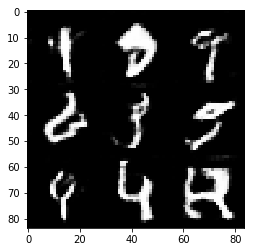

Epoch 1/2... Step 1610  Discriminator Loss: 0.9455... Generator Loss: 1.1145
Epoch 1/2... Step 1620  Discriminator Loss: 1.2630... Generator Loss: 0.5874
Epoch 1/2... Step 1630  Discriminator Loss: 1.5006... Generator Loss: 0.4382
Epoch 1/2... Step 1640  Discriminator Loss: 1.0614... Generator Loss: 0.7782
Epoch 1/2... Step 1650  Discriminator Loss: 1.1521... Generator Loss: 1.0630
Epoch 1/2... Step 1660  Discriminator Loss: 1.7101... Generator Loss: 0.3445
Epoch 1/2... Step 1670  Discriminator Loss: 1.3368... Generator Loss: 0.6176
Epoch 1/2... Step 1680  Discriminator Loss: 1.5348... Generator Loss: 0.4113
Epoch 1/2... Step 1690  Discriminator Loss: 1.3195... Generator Loss: 0.5758
Epoch 1/2... Step 1700  Discriminator Loss: 1.6673... Generator Loss: 0.3707


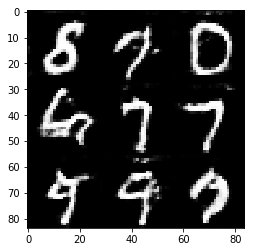

Epoch 1/2... Step 1710  Discriminator Loss: 1.0066... Generator Loss: 1.5316
Epoch 1/2... Step 1720  Discriminator Loss: 1.0417... Generator Loss: 0.7925
Epoch 1/2... Step 1730  Discriminator Loss: 1.0191... Generator Loss: 1.6060
Epoch 1/2... Step 1740  Discriminator Loss: 1.0152... Generator Loss: 1.0541
Epoch 1/2... Step 1750  Discriminator Loss: 1.4780... Generator Loss: 0.4454
Epoch 1/2... Step 1760  Discriminator Loss: 0.9817... Generator Loss: 0.9375
Epoch 1/2... Step 1770  Discriminator Loss: 0.8806... Generator Loss: 1.3843
Epoch 1/2... Step 1780  Discriminator Loss: 1.6947... Generator Loss: 0.3519
Epoch 1/2... Step 1790  Discriminator Loss: 0.7730... Generator Loss: 1.6151
Epoch 1/2... Step 1800  Discriminator Loss: 1.4520... Generator Loss: 0.4814


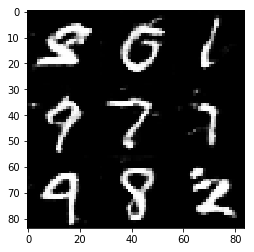

Epoch 1/2... Step 1810  Discriminator Loss: 1.2606... Generator Loss: 0.5927
Epoch 1/2... Step 1820  Discriminator Loss: 0.8729... Generator Loss: 1.1468
Epoch 1/2... Step 1830  Discriminator Loss: 1.3287... Generator Loss: 0.6283
Epoch 1/2... Step 1840  Discriminator Loss: 0.7815... Generator Loss: 1.8665
Epoch 1/2... Step 1850  Discriminator Loss: 0.7140... Generator Loss: 1.7275
Epoch 1/2... Step 1860  Discriminator Loss: 0.9132... Generator Loss: 1.2927
Epoch 1/2... Step 1870  Discriminator Loss: 0.8169... Generator Loss: 1.1109
Epoch 2/2... Step 1880  Discriminator Loss: 3.4080... Generator Loss: 5.4167
Epoch 2/2... Step 1890  Discriminator Loss: 1.0929... Generator Loss: 0.7926
Epoch 2/2... Step 1900  Discriminator Loss: 1.2350... Generator Loss: 0.5956


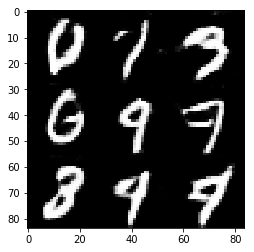

Epoch 2/2... Step 1910  Discriminator Loss: 0.8430... Generator Loss: 1.1352
Epoch 2/2... Step 1920  Discriminator Loss: 0.8542... Generator Loss: 1.0859
Epoch 2/2... Step 1930  Discriminator Loss: 1.5281... Generator Loss: 0.4765
Epoch 2/2... Step 1940  Discriminator Loss: 0.9406... Generator Loss: 1.2031
Epoch 2/2... Step 1950  Discriminator Loss: 0.8570... Generator Loss: 1.3648
Epoch 2/2... Step 1960  Discriminator Loss: 0.8557... Generator Loss: 1.0809
Epoch 2/2... Step 1970  Discriminator Loss: 1.7447... Generator Loss: 0.3341
Epoch 2/2... Step 1980  Discriminator Loss: 0.9423... Generator Loss: 1.3055
Epoch 2/2... Step 1990  Discriminator Loss: 1.2667... Generator Loss: 0.6671
Epoch 2/2... Step 2000  Discriminator Loss: 1.5813... Generator Loss: 2.5217


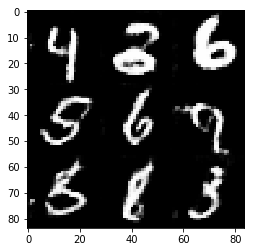

Epoch 2/2... Step 2010  Discriminator Loss: 1.2299... Generator Loss: 0.6007
Epoch 2/2... Step 2020  Discriminator Loss: 1.3927... Generator Loss: 0.5169
Epoch 2/2... Step 2030  Discriminator Loss: 1.3694... Generator Loss: 0.5569
Epoch 2/2... Step 2040  Discriminator Loss: 1.0289... Generator Loss: 0.9243
Epoch 2/2... Step 2050  Discriminator Loss: 1.0727... Generator Loss: 0.7863
Epoch 2/2... Step 2060  Discriminator Loss: 1.1860... Generator Loss: 0.6973
Epoch 2/2... Step 2070  Discriminator Loss: 1.4529... Generator Loss: 0.4855
Epoch 2/2... Step 2080  Discriminator Loss: 1.4406... Generator Loss: 0.5724
Epoch 2/2... Step 2090  Discriminator Loss: 0.8575... Generator Loss: 1.3858
Epoch 2/2... Step 2100  Discriminator Loss: 1.3540... Generator Loss: 2.9920


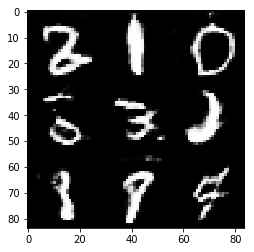

Epoch 2/2... Step 2110  Discriminator Loss: 0.8438... Generator Loss: 1.3156
Epoch 2/2... Step 2120  Discriminator Loss: 0.7600... Generator Loss: 1.9453
Epoch 2/2... Step 2130  Discriminator Loss: 1.3738... Generator Loss: 0.5270
Epoch 2/2... Step 2140  Discriminator Loss: 1.3085... Generator Loss: 0.6045
Epoch 2/2... Step 2150  Discriminator Loss: 0.9731... Generator Loss: 1.0701
Epoch 2/2... Step 2160  Discriminator Loss: 1.9173... Generator Loss: 0.3127
Epoch 2/2... Step 2170  Discriminator Loss: 0.9978... Generator Loss: 0.9766
Epoch 2/2... Step 2180  Discriminator Loss: 0.7653... Generator Loss: 1.3069
Epoch 2/2... Step 2190  Discriminator Loss: 2.1877... Generator Loss: 3.6193
Epoch 2/2... Step 2200  Discriminator Loss: 0.8438... Generator Loss: 1.2668


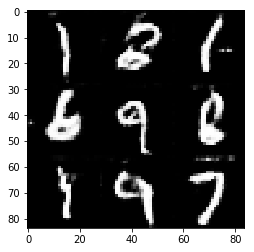

Epoch 2/2... Step 2210  Discriminator Loss: 1.2164... Generator Loss: 0.6142
Epoch 2/2... Step 2220  Discriminator Loss: 1.2832... Generator Loss: 0.6811
Epoch 2/2... Step 2230  Discriminator Loss: 1.1240... Generator Loss: 2.3853
Epoch 2/2... Step 2240  Discriminator Loss: 1.1116... Generator Loss: 0.7378
Epoch 2/2... Step 2250  Discriminator Loss: 0.8589... Generator Loss: 1.2673
Epoch 2/2... Step 2260  Discriminator Loss: 1.6724... Generator Loss: 0.4808
Epoch 2/2... Step 2270  Discriminator Loss: 1.2201... Generator Loss: 0.6757
Epoch 2/2... Step 2280  Discriminator Loss: 0.9962... Generator Loss: 0.8650
Epoch 2/2... Step 2290  Discriminator Loss: 0.9647... Generator Loss: 1.5579
Epoch 2/2... Step 2300  Discriminator Loss: 0.9301... Generator Loss: 1.6916


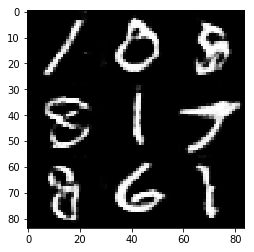

Epoch 2/2... Step 2310  Discriminator Loss: 1.1545... Generator Loss: 0.7734
Epoch 2/2... Step 2320  Discriminator Loss: 1.3593... Generator Loss: 0.5878
Epoch 2/2... Step 2330  Discriminator Loss: 0.8290... Generator Loss: 1.2729
Epoch 2/2... Step 2340  Discriminator Loss: 1.1926... Generator Loss: 1.9579
Epoch 2/2... Step 2350  Discriminator Loss: 1.1424... Generator Loss: 0.7563
Epoch 2/2... Step 2360  Discriminator Loss: 0.9693... Generator Loss: 1.7203
Epoch 2/2... Step 2370  Discriminator Loss: 1.2891... Generator Loss: 2.0061
Epoch 2/2... Step 2380  Discriminator Loss: 0.6968... Generator Loss: 1.4902
Epoch 2/2... Step 2390  Discriminator Loss: 1.1855... Generator Loss: 2.8288
Epoch 2/2... Step 2400  Discriminator Loss: 0.8832... Generator Loss: 1.4995


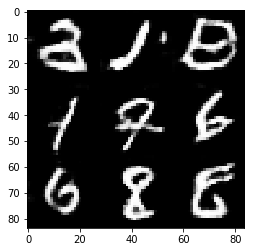

Epoch 2/2... Step 2410  Discriminator Loss: 0.7263... Generator Loss: 2.4840
Epoch 2/2... Step 2420  Discriminator Loss: 0.9434... Generator Loss: 0.9219
Epoch 2/2... Step 2430  Discriminator Loss: 0.8968... Generator Loss: 1.4553
Epoch 2/2... Step 2440  Discriminator Loss: 1.1409... Generator Loss: 0.6927
Epoch 2/2... Step 2450  Discriminator Loss: 0.8807... Generator Loss: 1.0296
Epoch 2/2... Step 2460  Discriminator Loss: 0.6489... Generator Loss: 2.0701
Epoch 2/2... Step 2470  Discriminator Loss: 0.8432... Generator Loss: 1.3199
Epoch 2/2... Step 2480  Discriminator Loss: 1.5551... Generator Loss: 0.4300
Epoch 2/2... Step 2490  Discriminator Loss: 0.9220... Generator Loss: 1.0040
Epoch 2/2... Step 2500  Discriminator Loss: 1.2587... Generator Loss: 0.6597


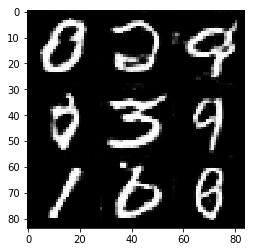

Epoch 2/2... Step 2510  Discriminator Loss: 0.7363... Generator Loss: 2.0015
Epoch 2/2... Step 2520  Discriminator Loss: 1.1258... Generator Loss: 1.8878
Epoch 2/2... Step 2530  Discriminator Loss: 0.9621... Generator Loss: 1.1189
Epoch 2/2... Step 2540  Discriminator Loss: 1.4621... Generator Loss: 0.6479
Epoch 2/2... Step 2550  Discriminator Loss: 0.7407... Generator Loss: 1.3476
Epoch 2/2... Step 2560  Discriminator Loss: 2.2082... Generator Loss: 0.2122
Epoch 2/2... Step 2570  Discriminator Loss: 1.2384... Generator Loss: 0.6884
Epoch 2/2... Step 2580  Discriminator Loss: 1.3512... Generator Loss: 0.5558
Epoch 2/2... Step 2590  Discriminator Loss: 0.8108... Generator Loss: 1.5340
Epoch 2/2... Step 2600  Discriminator Loss: 1.0417... Generator Loss: 0.9364


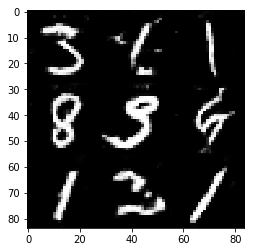

Epoch 2/2... Step 2610  Discriminator Loss: 0.9270... Generator Loss: 1.1042
Epoch 2/2... Step 2620  Discriminator Loss: 0.9672... Generator Loss: 1.9920
Epoch 2/2... Step 2630  Discriminator Loss: 1.0092... Generator Loss: 2.5462
Epoch 2/2... Step 2640  Discriminator Loss: 0.7477... Generator Loss: 2.0006
Epoch 2/2... Step 2650  Discriminator Loss: 1.2248... Generator Loss: 2.0201
Epoch 2/2... Step 2660  Discriminator Loss: 1.0899... Generator Loss: 0.8150
Epoch 2/2... Step 2670  Discriminator Loss: 1.0290... Generator Loss: 0.8213
Epoch 2/2... Step 2680  Discriminator Loss: 0.9597... Generator Loss: 0.8653
Epoch 2/2... Step 2690  Discriminator Loss: 0.7278... Generator Loss: 1.6987
Epoch 2/2... Step 2700  Discriminator Loss: 0.9745... Generator Loss: 0.8808


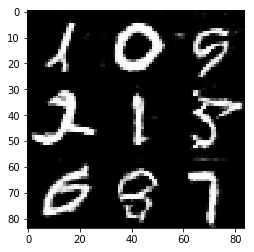

Epoch 2/2... Step 2710  Discriminator Loss: 0.9761... Generator Loss: 1.1683
Epoch 2/2... Step 2720  Discriminator Loss: 0.7247... Generator Loss: 1.5772
Epoch 2/2... Step 2730  Discriminator Loss: 1.2003... Generator Loss: 3.7543
Epoch 2/2... Step 2740  Discriminator Loss: 0.6599... Generator Loss: 1.5149
Epoch 2/2... Step 2750  Discriminator Loss: 0.9058... Generator Loss: 1.9016
Epoch 2/2... Step 2760  Discriminator Loss: 0.6335... Generator Loss: 1.7119
Epoch 2/2... Step 2770  Discriminator Loss: 1.2478... Generator Loss: 3.2341
Epoch 2/2... Step 2780  Discriminator Loss: 0.6480... Generator Loss: 1.5063
Epoch 2/2... Step 2790  Discriminator Loss: 0.8958... Generator Loss: 1.1391
Epoch 2/2... Step 2800  Discriminator Loss: 0.5985... Generator Loss: 2.0113


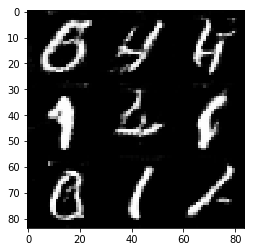

Epoch 2/2... Step 2810  Discriminator Loss: 0.8797... Generator Loss: 1.1850
Epoch 2/2... Step 2820  Discriminator Loss: 0.9255... Generator Loss: 1.1439
Epoch 2/2... Step 2830  Discriminator Loss: 0.6886... Generator Loss: 1.4337
Epoch 2/2... Step 2840  Discriminator Loss: 1.4196... Generator Loss: 0.5256
Epoch 2/2... Step 2850  Discriminator Loss: 0.6778... Generator Loss: 1.8664
Epoch 2/2... Step 2860  Discriminator Loss: 1.3684... Generator Loss: 0.5671
Epoch 2/2... Step 2870  Discriminator Loss: 1.1049... Generator Loss: 2.5818
Epoch 2/2... Step 2880  Discriminator Loss: 0.9211... Generator Loss: 1.2061
Epoch 2/2... Step 2890  Discriminator Loss: 0.6987... Generator Loss: 1.7820
Epoch 2/2... Step 2900  Discriminator Loss: 0.8784... Generator Loss: 1.0050


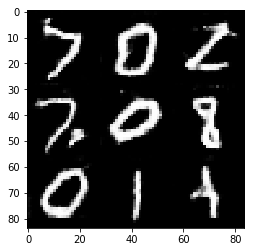

Epoch 2/2... Step 2910  Discriminator Loss: 0.5662... Generator Loss: 2.8042
Epoch 2/2... Step 2920  Discriminator Loss: 0.9102... Generator Loss: 2.9764
Epoch 2/2... Step 2930  Discriminator Loss: 1.1228... Generator Loss: 2.4405
Epoch 2/2... Step 2940  Discriminator Loss: 0.8028... Generator Loss: 1.4863
Epoch 2/2... Step 2950  Discriminator Loss: 0.9201... Generator Loss: 1.1375
Epoch 2/2... Step 2960  Discriminator Loss: 0.5199... Generator Loss: 2.1395
Epoch 2/2... Step 2970  Discriminator Loss: 0.6058... Generator Loss: 2.3044
Epoch 2/2... Step 2980  Discriminator Loss: 1.4913... Generator Loss: 0.5344
Epoch 2/2... Step 2990  Discriminator Loss: 1.0435... Generator Loss: 0.9083
Epoch 2/2... Step 3000  Discriminator Loss: 1.5621... Generator Loss: 0.5179


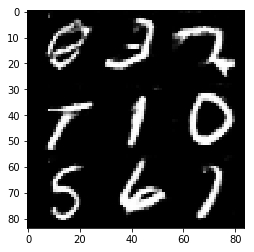

Epoch 2/2... Step 3010  Discriminator Loss: 1.0670... Generator Loss: 0.9549
Epoch 2/2... Step 3020  Discriminator Loss: 0.7858... Generator Loss: 2.0259
Epoch 2/2... Step 3030  Discriminator Loss: 0.8584... Generator Loss: 1.0715
Epoch 2/2... Step 3040  Discriminator Loss: 0.5296... Generator Loss: 2.2996
Epoch 2/2... Step 3050  Discriminator Loss: 0.8814... Generator Loss: 1.6685
Epoch 2/2... Step 3060  Discriminator Loss: 1.7618... Generator Loss: 0.3724
Epoch 2/2... Step 3070  Discriminator Loss: 1.0682... Generator Loss: 2.4615
Epoch 2/2... Step 3080  Discriminator Loss: 1.1838... Generator Loss: 0.6461
Epoch 2/2... Step 3090  Discriminator Loss: 0.5651... Generator Loss: 2.0477
Epoch 2/2... Step 3100  Discriminator Loss: 0.7540... Generator Loss: 2.0970


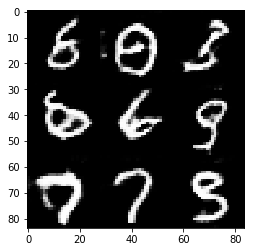

Epoch 2/2... Step 3110  Discriminator Loss: 0.9308... Generator Loss: 0.9741
Epoch 2/2... Step 3120  Discriminator Loss: 0.4883... Generator Loss: 2.5075
Epoch 2/2... Step 3130  Discriminator Loss: 0.7490... Generator Loss: 1.4127
Epoch 2/2... Step 3140  Discriminator Loss: 0.8314... Generator Loss: 1.2930
Epoch 2/2... Step 3150  Discriminator Loss: 1.4701... Generator Loss: 0.4994
Epoch 2/2... Step 3160  Discriminator Loss: 1.2684... Generator Loss: 2.5496
Epoch 2/2... Step 3170  Discriminator Loss: 0.9652... Generator Loss: 0.9890
Epoch 2/2... Step 3180  Discriminator Loss: 0.7795... Generator Loss: 1.2232
Epoch 2/2... Step 3190  Discriminator Loss: 0.7351... Generator Loss: 1.9350
Epoch 2/2... Step 3200  Discriminator Loss: 0.6715... Generator Loss: 1.7600


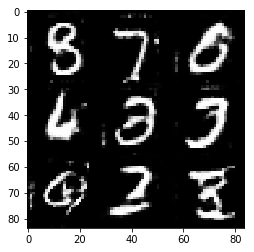

Epoch 2/2... Step 3210  Discriminator Loss: 1.1498... Generator Loss: 0.7086
Epoch 2/2... Step 3220  Discriminator Loss: 0.8200... Generator Loss: 1.0925
Epoch 2/2... Step 3230  Discriminator Loss: 1.0834... Generator Loss: 2.0900
Epoch 2/2... Step 3240  Discriminator Loss: 0.9854... Generator Loss: 2.0115
Epoch 2/2... Step 3250  Discriminator Loss: 0.7662... Generator Loss: 1.3096
Epoch 2/2... Step 3260  Discriminator Loss: 0.7903... Generator Loss: 2.3923
Epoch 2/2... Step 3270  Discriminator Loss: 1.1216... Generator Loss: 3.5786
Epoch 2/2... Step 3280  Discriminator Loss: 0.8787... Generator Loss: 1.3291
Epoch 2/2... Step 3290  Discriminator Loss: 0.9471... Generator Loss: 0.9584
Epoch 2/2... Step 3300  Discriminator Loss: 1.4444... Generator Loss: 0.5361


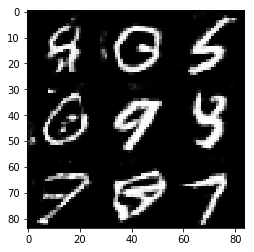

Epoch 2/2... Step 3310  Discriminator Loss: 1.0116... Generator Loss: 0.8845
Epoch 2/2... Step 3320  Discriminator Loss: 0.7977... Generator Loss: 1.1644
Epoch 2/2... Step 3330  Discriminator Loss: 0.7411... Generator Loss: 1.3977
Epoch 2/2... Step 3340  Discriminator Loss: 1.7769... Generator Loss: 0.3724
Epoch 2/2... Step 3350  Discriminator Loss: 0.5480... Generator Loss: 1.8930
Epoch 2/2... Step 3360  Discriminator Loss: 1.2130... Generator Loss: 0.6716
Epoch 2/2... Step 3370  Discriminator Loss: 1.0481... Generator Loss: 3.2688
Epoch 2/2... Step 3380  Discriminator Loss: 1.5415... Generator Loss: 0.4769
Epoch 2/2... Step 3390  Discriminator Loss: 0.9429... Generator Loss: 1.1300
Epoch 2/2... Step 3400  Discriminator Loss: 0.6698... Generator Loss: 1.4695


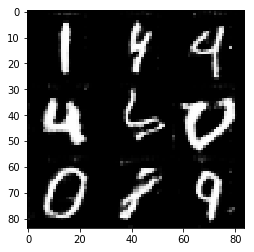

Epoch 2/2... Step 3410  Discriminator Loss: 0.7293... Generator Loss: 2.3444
Epoch 2/2... Step 3420  Discriminator Loss: 0.6831... Generator Loss: 1.5005
Epoch 2/2... Step 3430  Discriminator Loss: 0.6862... Generator Loss: 1.4565
Epoch 2/2... Step 3440  Discriminator Loss: 0.9887... Generator Loss: 1.4764
Epoch 2/2... Step 3450  Discriminator Loss: 0.6172... Generator Loss: 2.0889
Epoch 2/2... Step 3460  Discriminator Loss: 0.7477... Generator Loss: 1.3040
Epoch 2/2... Step 3470  Discriminator Loss: 0.8280... Generator Loss: 1.1431
Epoch 2/2... Step 3480  Discriminator Loss: 0.7982... Generator Loss: 1.3044
Epoch 2/2... Step 3490  Discriminator Loss: 1.1912... Generator Loss: 0.6720
Epoch 2/2... Step 3500  Discriminator Loss: 0.8810... Generator Loss: 1.0877


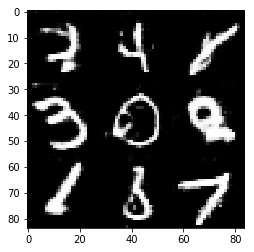

Epoch 2/2... Step 3510  Discriminator Loss: 1.3059... Generator Loss: 0.7672
Epoch 2/2... Step 3520  Discriminator Loss: 0.9164... Generator Loss: 1.0106
Epoch 2/2... Step 3530  Discriminator Loss: 0.5786... Generator Loss: 1.6871
Epoch 2/2... Step 3540  Discriminator Loss: 0.8109... Generator Loss: 3.5343
Epoch 2/2... Step 3550  Discriminator Loss: 0.5159... Generator Loss: 2.2713
Epoch 2/2... Step 3560  Discriminator Loss: 0.6050... Generator Loss: 2.3256
Epoch 2/2... Step 3570  Discriminator Loss: 0.7437... Generator Loss: 1.3647
Epoch 2/2... Step 3580  Discriminator Loss: 0.7930... Generator Loss: 1.1561
Epoch 2/2... Step 3590  Discriminator Loss: 0.9573... Generator Loss: 0.9143
Epoch 2/2... Step 3600  Discriminator Loss: 0.9597... Generator Loss: 2.6134


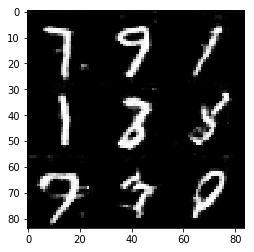

Epoch 2/2... Step 3610  Discriminator Loss: 0.5701... Generator Loss: 1.8218
Epoch 2/2... Step 3620  Discriminator Loss: 0.9278... Generator Loss: 0.9618
Epoch 2/2... Step 3630  Discriminator Loss: 0.9465... Generator Loss: 2.7079
Epoch 2/2... Step 3640  Discriminator Loss: 0.6556... Generator Loss: 1.6586
Epoch 2/2... Step 3650  Discriminator Loss: 0.8477... Generator Loss: 1.6722
Epoch 2/2... Step 3660  Discriminator Loss: 2.2505... Generator Loss: 0.2761
Epoch 2/2... Step 3670  Discriminator Loss: 0.7889... Generator Loss: 2.1117
Epoch 2/2... Step 3680  Discriminator Loss: 0.6675... Generator Loss: 1.4741
Epoch 2/2... Step 3690  Discriminator Loss: 0.7576... Generator Loss: 1.3427
Epoch 2/2... Step 3700  Discriminator Loss: 0.8437... Generator Loss: 2.1344


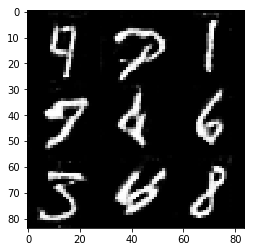

Epoch 2/2... Step 3710  Discriminator Loss: 0.7151... Generator Loss: 1.3439
Epoch 2/2... Step 3720  Discriminator Loss: 0.7075... Generator Loss: 1.6069
Epoch 2/2... Step 3730  Discriminator Loss: 0.5401... Generator Loss: 2.0085
Epoch 2/2... Step 3740  Discriminator Loss: 1.0105... Generator Loss: 1.4057
Epoch 2/2... Step 3750  Discriminator Loss: 0.9035... Generator Loss: 1.2142


In [40]:
batch_size = 32 #128
z_dim = 100
learning_rate = 0.0005 #0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10  Discriminator Loss: 0.4925... Generator Loss: 3.3332
Epoch 1/1... Step 20  Discriminator Loss: 0.6336... Generator Loss: 1.9485
Epoch 1/1... Step 30  Discriminator Loss: 8.1524... Generator Loss: 0.0028
Epoch 1/1... Step 40  Discriminator Loss: 2.3295... Generator Loss: 0.3700
Epoch 1/1... Step 50  Discriminator Loss: 2.8505... Generator Loss: 0.1199
Epoch 1/1... Step 60  Discriminator Loss: 1.6714... Generator Loss: 0.6307
Epoch 1/1... Step 70  Discriminator Loss: 1.6302... Generator Loss: 0.4260
Epoch 1/1... Step 80  Discriminator Loss: 0.6011... Generator Loss: 1.7975
Epoch 1/1... Step 90  Discriminator Loss: 3.6730... Generator Loss: 9.2273
Epoch 1/1... Step 100  Discriminator Loss: 0.5287... Generator Loss: 3.8804


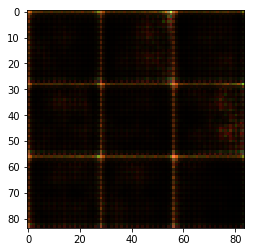

Epoch 1/1... Step 110  Discriminator Loss: 0.5551... Generator Loss: 1.8760
Epoch 1/1... Step 120  Discriminator Loss: 0.8453... Generator Loss: 1.0615
Epoch 1/1... Step 130  Discriminator Loss: 1.6444... Generator Loss: 0.3826
Epoch 1/1... Step 140  Discriminator Loss: 0.4890... Generator Loss: 2.7006
Epoch 1/1... Step 150  Discriminator Loss: 1.1628... Generator Loss: 0.8029
Epoch 1/1... Step 160  Discriminator Loss: 1.1115... Generator Loss: 0.7774
Epoch 1/1... Step 170  Discriminator Loss: 1.3980... Generator Loss: 3.4937
Epoch 1/1... Step 180  Discriminator Loss: 1.1375... Generator Loss: 2.2394
Epoch 1/1... Step 190  Discriminator Loss: 1.3782... Generator Loss: 1.2691
Epoch 1/1... Step 200  Discriminator Loss: 1.4052... Generator Loss: 0.5170


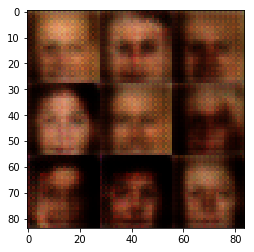

Epoch 1/1... Step 210  Discriminator Loss: 1.3041... Generator Loss: 1.7459
Epoch 1/1... Step 220  Discriminator Loss: 0.8395... Generator Loss: 1.5550
Epoch 1/1... Step 230  Discriminator Loss: 1.3718... Generator Loss: 0.7789
Epoch 1/1... Step 240  Discriminator Loss: 1.3233... Generator Loss: 0.9043
Epoch 1/1... Step 250  Discriminator Loss: 1.0867... Generator Loss: 0.8389
Epoch 1/1... Step 260  Discriminator Loss: 2.5584... Generator Loss: 0.1370
Epoch 1/1... Step 270  Discriminator Loss: 1.4077... Generator Loss: 1.1623
Epoch 1/1... Step 280  Discriminator Loss: 1.2152... Generator Loss: 0.7557
Epoch 1/1... Step 290  Discriminator Loss: 1.1149... Generator Loss: 1.5017
Epoch 1/1... Step 300  Discriminator Loss: 0.9351... Generator Loss: 1.6283


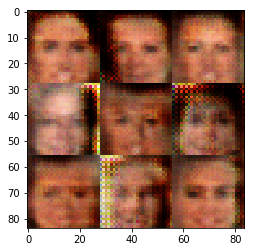

Epoch 1/1... Step 310  Discriminator Loss: 1.3720... Generator Loss: 0.6438
Epoch 1/1... Step 320  Discriminator Loss: 1.3076... Generator Loss: 0.5177
Epoch 1/1... Step 330  Discriminator Loss: 1.6481... Generator Loss: 1.6543
Epoch 1/1... Step 340  Discriminator Loss: 1.9858... Generator Loss: 2.3103
Epoch 1/1... Step 350  Discriminator Loss: 1.1727... Generator Loss: 0.7013
Epoch 1/1... Step 360  Discriminator Loss: 3.1447... Generator Loss: 3.1042
Epoch 1/1... Step 370  Discriminator Loss: 1.4727... Generator Loss: 0.6730
Epoch 1/1... Step 380  Discriminator Loss: 1.0981... Generator Loss: 0.9549
Epoch 1/1... Step 390  Discriminator Loss: 1.3853... Generator Loss: 0.5328
Epoch 1/1... Step 400  Discriminator Loss: 1.3482... Generator Loss: 0.5511


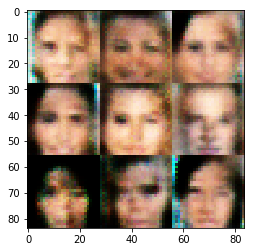

Epoch 1/1... Step 410  Discriminator Loss: 0.9562... Generator Loss: 1.0805
Epoch 1/1... Step 420  Discriminator Loss: 1.4627... Generator Loss: 1.0200
Epoch 1/1... Step 430  Discriminator Loss: 1.3435... Generator Loss: 0.5993
Epoch 1/1... Step 440  Discriminator Loss: 1.2727... Generator Loss: 1.3473
Epoch 1/1... Step 450  Discriminator Loss: 1.0900... Generator Loss: 1.4899
Epoch 1/1... Step 460  Discriminator Loss: 0.8340... Generator Loss: 1.1470
Epoch 1/1... Step 470  Discriminator Loss: 1.2175... Generator Loss: 0.9197
Epoch 1/1... Step 480  Discriminator Loss: 1.1402... Generator Loss: 0.9397
Epoch 1/1... Step 490  Discriminator Loss: 1.1349... Generator Loss: 0.8054
Epoch 1/1... Step 500  Discriminator Loss: 1.3341... Generator Loss: 0.7569


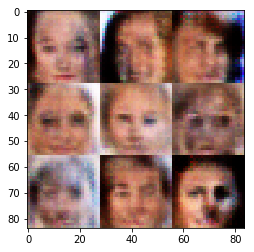

Epoch 1/1... Step 510  Discriminator Loss: 1.4070... Generator Loss: 0.7161
Epoch 1/1... Step 520  Discriminator Loss: 1.3603... Generator Loss: 0.7754
Epoch 1/1... Step 530  Discriminator Loss: 1.1152... Generator Loss: 1.0898
Epoch 1/1... Step 540  Discriminator Loss: 0.9134... Generator Loss: 1.7972
Epoch 1/1... Step 550  Discriminator Loss: 1.6825... Generator Loss: 0.3351
Epoch 1/1... Step 560  Discriminator Loss: 1.1307... Generator Loss: 1.3294
Epoch 1/1... Step 570  Discriminator Loss: 1.2706... Generator Loss: 0.7323
Epoch 1/1... Step 580  Discriminator Loss: 1.0011... Generator Loss: 0.7716
Epoch 1/1... Step 590  Discriminator Loss: 1.6132... Generator Loss: 0.6146
Epoch 1/1... Step 600  Discriminator Loss: 1.3555... Generator Loss: 0.6323


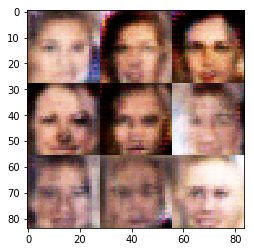

Epoch 1/1... Step 610  Discriminator Loss: 1.1450... Generator Loss: 0.7297
Epoch 1/1... Step 620  Discriminator Loss: 0.9171... Generator Loss: 0.9938
Epoch 1/1... Step 630  Discriminator Loss: 1.2854... Generator Loss: 0.8911
Epoch 1/1... Step 640  Discriminator Loss: 1.0045... Generator Loss: 1.2094
Epoch 1/1... Step 650  Discriminator Loss: 1.0518... Generator Loss: 0.9383
Epoch 1/1... Step 660  Discriminator Loss: 1.0516... Generator Loss: 1.8506
Epoch 1/1... Step 670  Discriminator Loss: 1.0621... Generator Loss: 1.5653
Epoch 1/1... Step 680  Discriminator Loss: 1.3282... Generator Loss: 0.5715
Epoch 1/1... Step 690  Discriminator Loss: 1.3029... Generator Loss: 0.8357
Epoch 1/1... Step 700  Discriminator Loss: 1.1194... Generator Loss: 0.8247


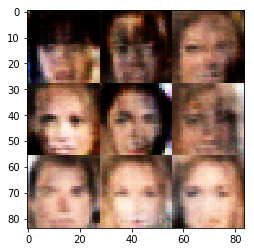

Epoch 1/1... Step 710  Discriminator Loss: 1.1109... Generator Loss: 0.8237
Epoch 1/1... Step 720  Discriminator Loss: 1.2929... Generator Loss: 0.6570
Epoch 1/1... Step 730  Discriminator Loss: 3.6297... Generator Loss: 3.0828
Epoch 1/1... Step 740  Discriminator Loss: 1.4986... Generator Loss: 0.7527
Epoch 1/1... Step 750  Discriminator Loss: 1.4954... Generator Loss: 0.6684
Epoch 1/1... Step 760  Discriminator Loss: 1.4372... Generator Loss: 0.7160
Epoch 1/1... Step 770  Discriminator Loss: 1.4179... Generator Loss: 0.7837
Epoch 1/1... Step 780  Discriminator Loss: 1.3814... Generator Loss: 0.5734
Epoch 1/1... Step 790  Discriminator Loss: 1.2827... Generator Loss: 0.8358
Epoch 1/1... Step 800  Discriminator Loss: 1.5609... Generator Loss: 0.4945


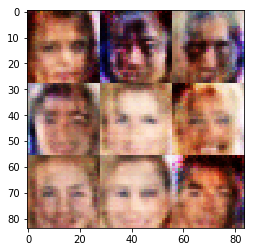

Epoch 1/1... Step 810  Discriminator Loss: 1.4074... Generator Loss: 0.5724
Epoch 1/1... Step 820  Discriminator Loss: 1.5046... Generator Loss: 0.4149
Epoch 1/1... Step 830  Discriminator Loss: 1.1771... Generator Loss: 0.9611
Epoch 1/1... Step 840  Discriminator Loss: 1.0358... Generator Loss: 1.0488
Epoch 1/1... Step 850  Discriminator Loss: 1.6538... Generator Loss: 0.4023
Epoch 1/1... Step 860  Discriminator Loss: 1.2547... Generator Loss: 0.9107
Epoch 1/1... Step 870  Discriminator Loss: 0.8634... Generator Loss: 1.0504
Epoch 1/1... Step 880  Discriminator Loss: 1.3825... Generator Loss: 0.4750
Epoch 1/1... Step 890  Discriminator Loss: 1.3281... Generator Loss: 0.9412
Epoch 1/1... Step 900  Discriminator Loss: 1.3317... Generator Loss: 0.6957


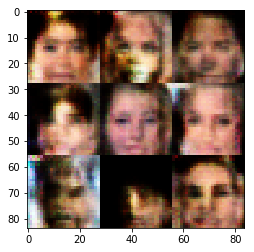

Epoch 1/1... Step 910  Discriminator Loss: 1.2540... Generator Loss: 0.7473
Epoch 1/1... Step 920  Discriminator Loss: 3.9775... Generator Loss: 3.4222
Epoch 1/1... Step 930  Discriminator Loss: 1.2563... Generator Loss: 0.8203
Epoch 1/1... Step 940  Discriminator Loss: 1.5081... Generator Loss: 0.5941
Epoch 1/1... Step 950  Discriminator Loss: 1.5374... Generator Loss: 0.6369
Epoch 1/1... Step 960  Discriminator Loss: 1.0738... Generator Loss: 1.5216
Epoch 1/1... Step 970  Discriminator Loss: 1.1631... Generator Loss: 0.8164
Epoch 1/1... Step 980  Discriminator Loss: 0.9914... Generator Loss: 1.3940
Epoch 1/1... Step 990  Discriminator Loss: 1.3736... Generator Loss: 0.7154
Epoch 1/1... Step 1000  Discriminator Loss: 1.2283... Generator Loss: 0.6717


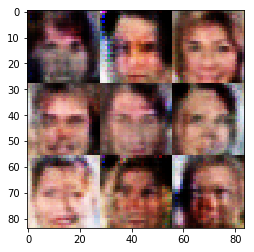

Epoch 1/1... Step 1010  Discriminator Loss: 1.6386... Generator Loss: 0.3747
Epoch 1/1... Step 1020  Discriminator Loss: 1.1227... Generator Loss: 1.0913
Epoch 1/1... Step 1030  Discriminator Loss: 1.5911... Generator Loss: 0.4939
Epoch 1/1... Step 1040  Discriminator Loss: 1.7515... Generator Loss: 0.3129
Epoch 1/1... Step 1050  Discriminator Loss: 1.1616... Generator Loss: 0.9350
Epoch 1/1... Step 1060  Discriminator Loss: 1.3598... Generator Loss: 0.9108
Epoch 1/1... Step 1070  Discriminator Loss: 1.3220... Generator Loss: 0.5014
Epoch 1/1... Step 1080  Discriminator Loss: 1.6174... Generator Loss: 0.5217
Epoch 1/1... Step 1090  Discriminator Loss: 1.4019... Generator Loss: 0.6775
Epoch 1/1... Step 1100  Discriminator Loss: 1.4907... Generator Loss: 0.6616


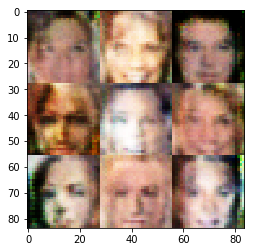

Epoch 1/1... Step 1110  Discriminator Loss: 1.3388... Generator Loss: 0.6386
Epoch 1/1... Step 1120  Discriminator Loss: 1.0807... Generator Loss: 1.1296
Epoch 1/1... Step 1130  Discriminator Loss: 1.5342... Generator Loss: 0.5579
Epoch 1/1... Step 1140  Discriminator Loss: 1.0717... Generator Loss: 0.9884
Epoch 1/1... Step 1150  Discriminator Loss: 1.2750... Generator Loss: 0.7871
Epoch 1/1... Step 1160  Discriminator Loss: 1.5643... Generator Loss: 0.7667
Epoch 1/1... Step 1170  Discriminator Loss: 1.2965... Generator Loss: 0.7460
Epoch 1/1... Step 1180  Discriminator Loss: 1.5459... Generator Loss: 0.7417
Epoch 1/1... Step 1190  Discriminator Loss: 1.1120... Generator Loss: 0.8110
Epoch 1/1... Step 1200  Discriminator Loss: 1.2661... Generator Loss: 0.8483


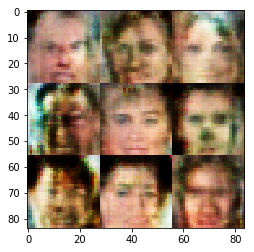

Epoch 1/1... Step 1210  Discriminator Loss: 1.3139... Generator Loss: 0.8205
Epoch 1/1... Step 1220  Discriminator Loss: 1.2016... Generator Loss: 0.9379
Epoch 1/1... Step 1230  Discriminator Loss: 0.8724... Generator Loss: 1.5772
Epoch 1/1... Step 1240  Discriminator Loss: 1.4231... Generator Loss: 0.7995
Epoch 1/1... Step 1250  Discriminator Loss: 1.4383... Generator Loss: 0.7075
Epoch 1/1... Step 1260  Discriminator Loss: 1.3770... Generator Loss: 0.8541
Epoch 1/1... Step 1270  Discriminator Loss: 1.5405... Generator Loss: 1.3761
Epoch 1/1... Step 1280  Discriminator Loss: 2.1020... Generator Loss: 2.1565
Epoch 1/1... Step 1290  Discriminator Loss: 1.2704... Generator Loss: 0.7202
Epoch 1/1... Step 1300  Discriminator Loss: 1.3066... Generator Loss: 1.0668


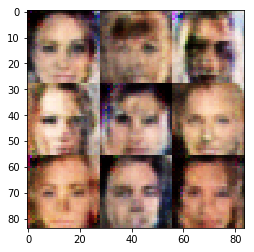

Epoch 1/1... Step 1310  Discriminator Loss: 1.1753... Generator Loss: 0.9342
Epoch 1/1... Step 1320  Discriminator Loss: 1.5458... Generator Loss: 0.4760
Epoch 1/1... Step 1330  Discriminator Loss: 1.1950... Generator Loss: 0.9607
Epoch 1/1... Step 1340  Discriminator Loss: 1.2259... Generator Loss: 1.1176
Epoch 1/1... Step 1350  Discriminator Loss: 1.3483... Generator Loss: 0.7162
Epoch 1/1... Step 1360  Discriminator Loss: 1.4782... Generator Loss: 0.6941
Epoch 1/1... Step 1370  Discriminator Loss: 0.9320... Generator Loss: 1.1442
Epoch 1/1... Step 1380  Discriminator Loss: 1.3239... Generator Loss: 0.7571
Epoch 1/1... Step 1390  Discriminator Loss: 1.4474... Generator Loss: 0.6116
Epoch 1/1... Step 1400  Discriminator Loss: 1.4702... Generator Loss: 1.5099


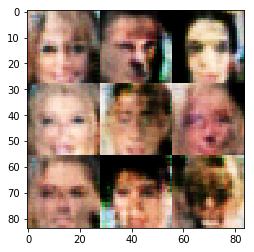

Epoch 1/1... Step 1410  Discriminator Loss: 1.3390... Generator Loss: 1.1207
Epoch 1/1... Step 1420  Discriminator Loss: 1.3506... Generator Loss: 0.7239
Epoch 1/1... Step 1430  Discriminator Loss: 1.1164... Generator Loss: 0.7274
Epoch 1/1... Step 1440  Discriminator Loss: 1.4387... Generator Loss: 0.6685
Epoch 1/1... Step 1450  Discriminator Loss: 1.4067... Generator Loss: 0.4644
Epoch 1/1... Step 1460  Discriminator Loss: 1.0545... Generator Loss: 1.4259
Epoch 1/1... Step 1470  Discriminator Loss: 1.5285... Generator Loss: 1.0655
Epoch 1/1... Step 1480  Discriminator Loss: 1.0153... Generator Loss: 0.9990
Epoch 1/1... Step 1490  Discriminator Loss: 1.2116... Generator Loss: 0.7367
Epoch 1/1... Step 1500  Discriminator Loss: 1.4374... Generator Loss: 0.8361


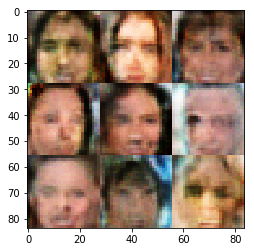

Epoch 1/1... Step 1510  Discriminator Loss: 1.1879... Generator Loss: 0.7520
Epoch 1/1... Step 1520  Discriminator Loss: 1.5558... Generator Loss: 0.4268
Epoch 1/1... Step 1530  Discriminator Loss: 1.6929... Generator Loss: 0.3524
Epoch 1/1... Step 1540  Discriminator Loss: 1.4049... Generator Loss: 0.8498
Epoch 1/1... Step 1550  Discriminator Loss: 1.1969... Generator Loss: 0.7663
Epoch 1/1... Step 1560  Discriminator Loss: 1.5904... Generator Loss: 0.4305
Epoch 1/1... Step 1570  Discriminator Loss: 1.3129... Generator Loss: 0.6496
Epoch 1/1... Step 1580  Discriminator Loss: 1.3098... Generator Loss: 0.8199
Epoch 1/1... Step 1590  Discriminator Loss: 1.1777... Generator Loss: 0.6146
Epoch 1/1... Step 1600  Discriminator Loss: 1.4664... Generator Loss: 0.7268


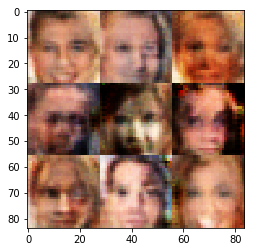

Epoch 1/1... Step 1610  Discriminator Loss: 1.3749... Generator Loss: 0.5393
Epoch 1/1... Step 1620  Discriminator Loss: 1.5172... Generator Loss: 1.5067
Epoch 1/1... Step 1630  Discriminator Loss: 1.9427... Generator Loss: 1.7543
Epoch 1/1... Step 1640  Discriminator Loss: 1.4141... Generator Loss: 0.4848
Epoch 1/1... Step 1650  Discriminator Loss: 1.7181... Generator Loss: 0.3726
Epoch 1/1... Step 1660  Discriminator Loss: 1.2638... Generator Loss: 1.3358
Epoch 1/1... Step 1670  Discriminator Loss: 1.2921... Generator Loss: 0.7993
Epoch 1/1... Step 1680  Discriminator Loss: 1.3443... Generator Loss: 0.9704
Epoch 1/1... Step 1690  Discriminator Loss: 1.4957... Generator Loss: 1.3517
Epoch 1/1... Step 1700  Discriminator Loss: 1.5196... Generator Loss: 0.3971


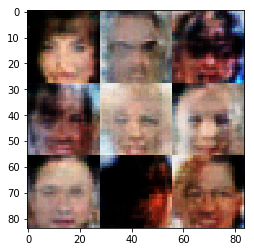

Epoch 1/1... Step 1710  Discriminator Loss: 1.2868... Generator Loss: 1.2505
Epoch 1/1... Step 1720  Discriminator Loss: 1.3099... Generator Loss: 0.7742
Epoch 1/1... Step 1730  Discriminator Loss: 1.4448... Generator Loss: 0.7266
Epoch 1/1... Step 1740  Discriminator Loss: 1.1934... Generator Loss: 0.6405
Epoch 1/1... Step 1750  Discriminator Loss: 1.4700... Generator Loss: 0.7255
Epoch 1/1... Step 1760  Discriminator Loss: 1.3503... Generator Loss: 0.8365
Epoch 1/1... Step 1770  Discriminator Loss: 1.4358... Generator Loss: 0.7729
Epoch 1/1... Step 1780  Discriminator Loss: 1.3342... Generator Loss: 0.6592
Epoch 1/1... Step 1790  Discriminator Loss: 0.9512... Generator Loss: 1.0567
Epoch 1/1... Step 1800  Discriminator Loss: 1.5228... Generator Loss: 0.5841


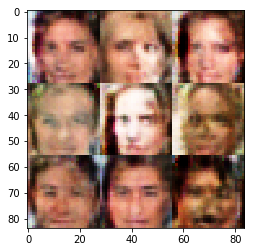

Epoch 1/1... Step 1810  Discriminator Loss: 1.3525... Generator Loss: 0.8636
Epoch 1/1... Step 1820  Discriminator Loss: 1.3650... Generator Loss: 0.6736
Epoch 1/1... Step 1830  Discriminator Loss: 1.5779... Generator Loss: 0.3994
Epoch 1/1... Step 1840  Discriminator Loss: 1.2982... Generator Loss: 0.6977
Epoch 1/1... Step 1850  Discriminator Loss: 1.5060... Generator Loss: 0.6639
Epoch 1/1... Step 1860  Discriminator Loss: 1.2611... Generator Loss: 0.7703
Epoch 1/1... Step 1870  Discriminator Loss: 1.1501... Generator Loss: 0.7027
Epoch 1/1... Step 1880  Discriminator Loss: 1.2229... Generator Loss: 0.9292
Epoch 1/1... Step 1890  Discriminator Loss: 1.5884... Generator Loss: 0.5495
Epoch 1/1... Step 1900  Discriminator Loss: 1.3101... Generator Loss: 0.8216


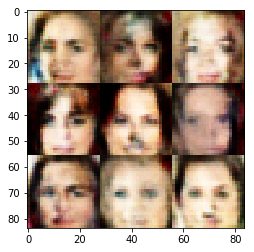

Epoch 1/1... Step 1910  Discriminator Loss: 1.3764... Generator Loss: 0.5303
Epoch 1/1... Step 1920  Discriminator Loss: 1.2629... Generator Loss: 0.8189
Epoch 1/1... Step 1930  Discriminator Loss: 1.1906... Generator Loss: 0.7877
Epoch 1/1... Step 1940  Discriminator Loss: 1.3996... Generator Loss: 0.5442
Epoch 1/1... Step 1950  Discriminator Loss: 0.8962... Generator Loss: 0.9640
Epoch 1/1... Step 1960  Discriminator Loss: 2.2316... Generator Loss: 3.2822
Epoch 1/1... Step 1970  Discriminator Loss: 1.5830... Generator Loss: 1.6004
Epoch 1/1... Step 1980  Discriminator Loss: 1.3317... Generator Loss: 0.8715
Epoch 1/1... Step 1990  Discriminator Loss: 1.2854... Generator Loss: 1.0292
Epoch 1/1... Step 2000  Discriminator Loss: 1.2682... Generator Loss: 0.7620


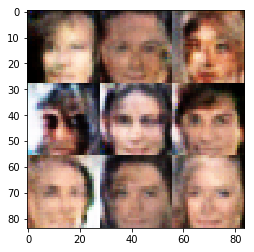

Epoch 1/1... Step 2010  Discriminator Loss: 1.4275... Generator Loss: 0.7971
Epoch 1/1... Step 2020  Discriminator Loss: 1.2360... Generator Loss: 0.7373
Epoch 1/1... Step 2030  Discriminator Loss: 1.3687... Generator Loss: 0.5520
Epoch 1/1... Step 2040  Discriminator Loss: 1.3584... Generator Loss: 0.9084
Epoch 1/1... Step 2050  Discriminator Loss: 1.2808... Generator Loss: 0.9066
Epoch 1/1... Step 2060  Discriminator Loss: 1.1550... Generator Loss: 0.6838
Epoch 1/1... Step 2070  Discriminator Loss: 1.3048... Generator Loss: 0.7502
Epoch 1/1... Step 2080  Discriminator Loss: 1.2331... Generator Loss: 0.7453
Epoch 1/1... Step 2090  Discriminator Loss: 1.2826... Generator Loss: 0.7492
Epoch 1/1... Step 2100  Discriminator Loss: 1.2988... Generator Loss: 0.9512


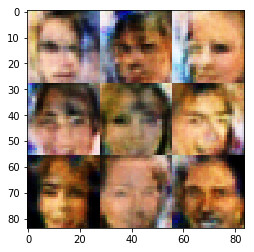

Epoch 1/1... Step 2110  Discriminator Loss: 1.3849... Generator Loss: 0.7529
Epoch 1/1... Step 2120  Discriminator Loss: 1.3217... Generator Loss: 0.6337
Epoch 1/1... Step 2130  Discriminator Loss: 1.4067... Generator Loss: 0.8714
Epoch 1/1... Step 2140  Discriminator Loss: 1.4369... Generator Loss: 0.7362
Epoch 1/1... Step 2150  Discriminator Loss: 1.5032... Generator Loss: 0.6418
Epoch 1/1... Step 2160  Discriminator Loss: 1.3974... Generator Loss: 0.8101
Epoch 1/1... Step 2170  Discriminator Loss: 1.3543... Generator Loss: 0.8730
Epoch 1/1... Step 2180  Discriminator Loss: 1.4006... Generator Loss: 0.7303
Epoch 1/1... Step 2190  Discriminator Loss: 1.3232... Generator Loss: 0.7274
Epoch 1/1... Step 2200  Discriminator Loss: 1.3879... Generator Loss: 0.6394


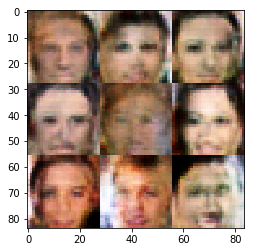

Epoch 1/1... Step 2210  Discriminator Loss: 1.3469... Generator Loss: 0.6763
Epoch 1/1... Step 2220  Discriminator Loss: 1.6651... Generator Loss: 1.4237
Epoch 1/1... Step 2230  Discriminator Loss: 1.5522... Generator Loss: 1.6714
Epoch 1/1... Step 2240  Discriminator Loss: 1.7505... Generator Loss: 1.5452
Epoch 1/1... Step 2250  Discriminator Loss: 1.2748... Generator Loss: 0.8162
Epoch 1/1... Step 2260  Discriminator Loss: 1.1127... Generator Loss: 1.5491
Epoch 1/1... Step 2270  Discriminator Loss: 1.5217... Generator Loss: 0.4305
Epoch 1/1... Step 2280  Discriminator Loss: 1.2953... Generator Loss: 0.6269
Epoch 1/1... Step 2290  Discriminator Loss: 1.4442... Generator Loss: 0.5135
Epoch 1/1... Step 2300  Discriminator Loss: 1.2671... Generator Loss: 0.5675


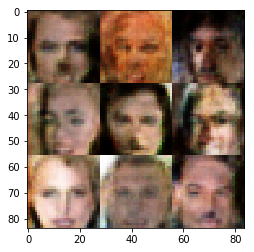

Epoch 1/1... Step 2310  Discriminator Loss: 1.1944... Generator Loss: 1.1393
Epoch 1/1... Step 2320  Discriminator Loss: 1.0079... Generator Loss: 1.3629
Epoch 1/1... Step 2330  Discriminator Loss: 1.5056... Generator Loss: 0.7187
Epoch 1/1... Step 2340  Discriminator Loss: 1.3481... Generator Loss: 0.7268
Epoch 1/1... Step 2350  Discriminator Loss: 1.4056... Generator Loss: 0.7620
Epoch 1/1... Step 2360  Discriminator Loss: 1.2869... Generator Loss: 0.5279
Epoch 1/1... Step 2370  Discriminator Loss: 1.4210... Generator Loss: 0.6704
Epoch 1/1... Step 2380  Discriminator Loss: 1.4091... Generator Loss: 0.7917
Epoch 1/1... Step 2390  Discriminator Loss: 1.3396... Generator Loss: 0.6917
Epoch 1/1... Step 2400  Discriminator Loss: 1.3995... Generator Loss: 0.5700


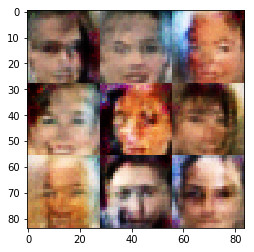

Epoch 1/1... Step 2410  Discriminator Loss: 0.9463... Generator Loss: 0.9923
Epoch 1/1... Step 2420  Discriminator Loss: 1.1919... Generator Loss: 1.0171
Epoch 1/1... Step 2430  Discriminator Loss: 1.3607... Generator Loss: 0.7168
Epoch 1/1... Step 2440  Discriminator Loss: 1.2076... Generator Loss: 0.7717
Epoch 1/1... Step 2450  Discriminator Loss: 1.1639... Generator Loss: 1.1361
Epoch 1/1... Step 2460  Discriminator Loss: 1.4026... Generator Loss: 0.7806
Epoch 1/1... Step 2470  Discriminator Loss: 1.3363... Generator Loss: 0.7052
Epoch 1/1... Step 2480  Discriminator Loss: 1.4690... Generator Loss: 0.5899
Epoch 1/1... Step 2490  Discriminator Loss: 1.3101... Generator Loss: 0.6901
Epoch 1/1... Step 2500  Discriminator Loss: 1.3772... Generator Loss: 0.8991


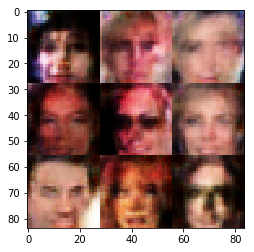

Epoch 1/1... Step 2510  Discriminator Loss: 1.3106... Generator Loss: 0.5778
Epoch 1/1... Step 2520  Discriminator Loss: 1.4409... Generator Loss: 1.0985
Epoch 1/1... Step 2530  Discriminator Loss: 1.2709... Generator Loss: 0.8626
Epoch 1/1... Step 2540  Discriminator Loss: 1.4834... Generator Loss: 1.2391
Epoch 1/1... Step 2550  Discriminator Loss: 1.2028... Generator Loss: 1.0061
Epoch 1/1... Step 2560  Discriminator Loss: 1.3157... Generator Loss: 0.7923
Epoch 1/1... Step 2570  Discriminator Loss: 1.4013... Generator Loss: 0.6211
Epoch 1/1... Step 2580  Discriminator Loss: 1.3386... Generator Loss: 1.0965
Epoch 1/1... Step 2590  Discriminator Loss: 1.3891... Generator Loss: 0.4525
Epoch 1/1... Step 2600  Discriminator Loss: 1.3419... Generator Loss: 0.8727


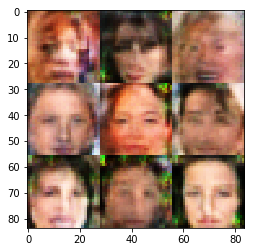

Epoch 1/1... Step 2610  Discriminator Loss: 1.2067... Generator Loss: 0.9971
Epoch 1/1... Step 2620  Discriminator Loss: 1.4890... Generator Loss: 0.4095
Epoch 1/1... Step 2630  Discriminator Loss: 1.4034... Generator Loss: 0.6068
Epoch 1/1... Step 2640  Discriminator Loss: 1.2960... Generator Loss: 0.7312
Epoch 1/1... Step 2650  Discriminator Loss: 1.3938... Generator Loss: 0.6429
Epoch 1/1... Step 2660  Discriminator Loss: 1.2552... Generator Loss: 0.5972
Epoch 1/1... Step 2670  Discriminator Loss: 1.4439... Generator Loss: 0.9454
Epoch 1/1... Step 2680  Discriminator Loss: 1.3317... Generator Loss: 0.6181
Epoch 1/1... Step 2690  Discriminator Loss: 1.2644... Generator Loss: 1.0539
Epoch 1/1... Step 2700  Discriminator Loss: 1.2453... Generator Loss: 0.8851


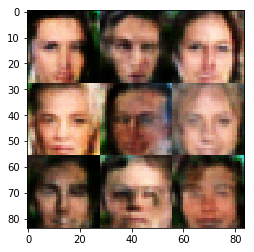

Epoch 1/1... Step 2710  Discriminator Loss: 1.2752... Generator Loss: 0.9324
Epoch 1/1... Step 2720  Discriminator Loss: 1.1501... Generator Loss: 1.0708
Epoch 1/1... Step 2730  Discriminator Loss: 1.0479... Generator Loss: 1.1445
Epoch 1/1... Step 2740  Discriminator Loss: 1.3505... Generator Loss: 0.7267
Epoch 1/1... Step 2750  Discriminator Loss: 1.4145... Generator Loss: 0.6709
Epoch 1/1... Step 2760  Discriminator Loss: 1.3049... Generator Loss: 0.8069
Epoch 1/1... Step 2770  Discriminator Loss: 1.2643... Generator Loss: 1.1553
Epoch 1/1... Step 2780  Discriminator Loss: 1.6035... Generator Loss: 0.3855
Epoch 1/1... Step 2790  Discriminator Loss: 1.3870... Generator Loss: 0.5069
Epoch 1/1... Step 2800  Discriminator Loss: 1.6292... Generator Loss: 0.3702


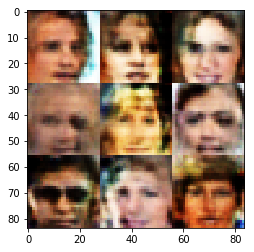

Epoch 1/1... Step 2810  Discriminator Loss: 1.1655... Generator Loss: 0.8194
Epoch 1/1... Step 2820  Discriminator Loss: 1.3799... Generator Loss: 0.9845
Epoch 1/1... Step 2830  Discriminator Loss: 1.2940... Generator Loss: 0.9197
Epoch 1/1... Step 2840  Discriminator Loss: 1.1715... Generator Loss: 0.6881
Epoch 1/1... Step 2850  Discriminator Loss: 1.3482... Generator Loss: 0.7187
Epoch 1/1... Step 2860  Discriminator Loss: 1.3241... Generator Loss: 1.3271
Epoch 1/1... Step 2870  Discriminator Loss: 1.4557... Generator Loss: 0.9804
Epoch 1/1... Step 2880  Discriminator Loss: 1.2382... Generator Loss: 0.6554
Epoch 1/1... Step 2890  Discriminator Loss: 1.4398... Generator Loss: 0.7768
Epoch 1/1... Step 2900  Discriminator Loss: 1.2726... Generator Loss: 0.5773


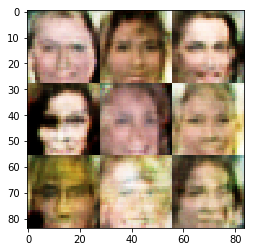

Epoch 1/1... Step 2910  Discriminator Loss: 1.1368... Generator Loss: 0.8051
Epoch 1/1... Step 2920  Discriminator Loss: 1.3840... Generator Loss: 0.6325
Epoch 1/1... Step 2930  Discriminator Loss: 1.4103... Generator Loss: 0.5501
Epoch 1/1... Step 2940  Discriminator Loss: 1.2405... Generator Loss: 0.7453
Epoch 1/1... Step 2950  Discriminator Loss: 1.2945... Generator Loss: 1.1621
Epoch 1/1... Step 2960  Discriminator Loss: 1.2164... Generator Loss: 0.5851
Epoch 1/1... Step 2970  Discriminator Loss: 1.1758... Generator Loss: 1.1199
Epoch 1/1... Step 2980  Discriminator Loss: 0.9714... Generator Loss: 1.2571
Epoch 1/1... Step 2990  Discriminator Loss: 1.3180... Generator Loss: 0.7556
Epoch 1/1... Step 3000  Discriminator Loss: 1.5059... Generator Loss: 1.0964


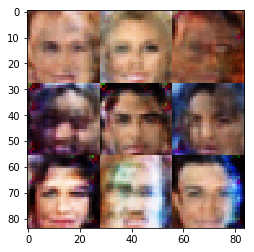

Epoch 1/1... Step 3010  Discriminator Loss: 1.3413... Generator Loss: 1.1420
Epoch 1/1... Step 3020  Discriminator Loss: 1.4848... Generator Loss: 0.4215
Epoch 1/1... Step 3030  Discriminator Loss: 1.2298... Generator Loss: 0.5949
Epoch 1/1... Step 3040  Discriminator Loss: 1.6469... Generator Loss: 0.3496
Epoch 1/1... Step 3050  Discriminator Loss: 0.8358... Generator Loss: 1.0336
Epoch 1/1... Step 3060  Discriminator Loss: 1.2714... Generator Loss: 0.7352
Epoch 1/1... Step 3070  Discriminator Loss: 1.3073... Generator Loss: 0.6616
Epoch 1/1... Step 3080  Discriminator Loss: 1.3402... Generator Loss: 1.5108
Epoch 1/1... Step 3090  Discriminator Loss: 1.3380... Generator Loss: 1.0227
Epoch 1/1... Step 3100  Discriminator Loss: 1.2950... Generator Loss: 0.6550


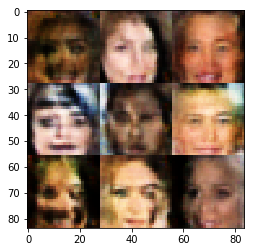

Epoch 1/1... Step 3110  Discriminator Loss: 1.2622... Generator Loss: 0.8456
Epoch 1/1... Step 3120  Discriminator Loss: 1.2920... Generator Loss: 0.6177
Epoch 1/1... Step 3130  Discriminator Loss: 1.3274... Generator Loss: 0.6379
Epoch 1/1... Step 3140  Discriminator Loss: 1.3599... Generator Loss: 0.5195
Epoch 1/1... Step 3150  Discriminator Loss: 1.3564... Generator Loss: 0.8965
Epoch 1/1... Step 3160  Discriminator Loss: 1.2702... Generator Loss: 0.5411
Epoch 1/1... Step 3170  Discriminator Loss: 1.7408... Generator Loss: 1.7453
Epoch 1/1... Step 3180  Discriminator Loss: 1.3054... Generator Loss: 0.5613
Epoch 1/1... Step 3190  Discriminator Loss: 1.1596... Generator Loss: 0.8588
Epoch 1/1... Step 3200  Discriminator Loss: 1.3560... Generator Loss: 0.7753


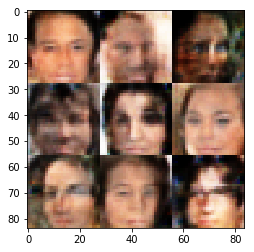

Epoch 1/1... Step 3210  Discriminator Loss: 1.2982... Generator Loss: 1.3626
Epoch 1/1... Step 3220  Discriminator Loss: 1.3189... Generator Loss: 0.8380
Epoch 1/1... Step 3230  Discriminator Loss: 1.1615... Generator Loss: 0.6806
Epoch 1/1... Step 3240  Discriminator Loss: 1.2415... Generator Loss: 0.6911
Epoch 1/1... Step 3250  Discriminator Loss: 1.1278... Generator Loss: 0.8418
Epoch 1/1... Step 3260  Discriminator Loss: 1.3294... Generator Loss: 0.6286
Epoch 1/1... Step 3270  Discriminator Loss: 1.4598... Generator Loss: 0.6274
Epoch 1/1... Step 3280  Discriminator Loss: 1.2038... Generator Loss: 0.7443
Epoch 1/1... Step 3290  Discriminator Loss: 1.1385... Generator Loss: 1.0373
Epoch 1/1... Step 3300  Discriminator Loss: 1.3381... Generator Loss: 0.8742


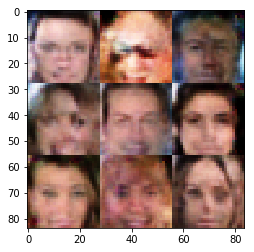

Epoch 1/1... Step 3310  Discriminator Loss: 1.3271... Generator Loss: 0.6752
Epoch 1/1... Step 3320  Discriminator Loss: 1.2854... Generator Loss: 0.8825
Epoch 1/1... Step 3330  Discriminator Loss: 1.4668... Generator Loss: 0.5275
Epoch 1/1... Step 3340  Discriminator Loss: 1.2999... Generator Loss: 0.6604
Epoch 1/1... Step 3350  Discriminator Loss: 1.3260... Generator Loss: 0.8255
Epoch 1/1... Step 3360  Discriminator Loss: 1.1509... Generator Loss: 1.0185
Epoch 1/1... Step 3370  Discriminator Loss: 1.0767... Generator Loss: 0.8657
Epoch 1/1... Step 3380  Discriminator Loss: 1.1946... Generator Loss: 0.8505
Epoch 1/1... Step 3390  Discriminator Loss: 1.4049... Generator Loss: 0.6587
Epoch 1/1... Step 3400  Discriminator Loss: 1.3355... Generator Loss: 0.7958


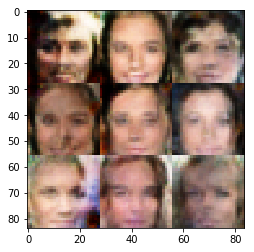

Epoch 1/1... Step 3410  Discriminator Loss: 1.1839... Generator Loss: 1.1435
Epoch 1/1... Step 3420  Discriminator Loss: 1.2806... Generator Loss: 0.6506
Epoch 1/1... Step 3430  Discriminator Loss: 1.2435... Generator Loss: 0.9559
Epoch 1/1... Step 3440  Discriminator Loss: 1.2469... Generator Loss: 0.8085
Epoch 1/1... Step 3450  Discriminator Loss: 1.0893... Generator Loss: 0.9406
Epoch 1/1... Step 3460  Discriminator Loss: 1.4736... Generator Loss: 1.7596
Epoch 1/1... Step 3470  Discriminator Loss: 1.5058... Generator Loss: 0.6912
Epoch 1/1... Step 3480  Discriminator Loss: 1.5048... Generator Loss: 1.4768
Epoch 1/1... Step 3490  Discriminator Loss: 1.2577... Generator Loss: 1.0474
Epoch 1/1... Step 3500  Discriminator Loss: 1.2688... Generator Loss: 0.8698


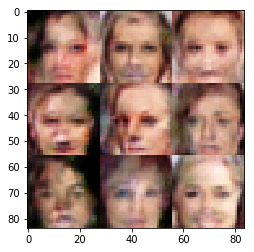

Epoch 1/1... Step 3510  Discriminator Loss: 1.2098... Generator Loss: 0.6507
Epoch 1/1... Step 3520  Discriminator Loss: 1.5440... Generator Loss: 1.2093
Epoch 1/1... Step 3530  Discriminator Loss: 1.2017... Generator Loss: 1.0152
Epoch 1/1... Step 3540  Discriminator Loss: 1.4009... Generator Loss: 0.5496
Epoch 1/1... Step 3550  Discriminator Loss: 1.2035... Generator Loss: 0.9391
Epoch 1/1... Step 3560  Discriminator Loss: 1.8180... Generator Loss: 0.2887
Epoch 1/1... Step 3570  Discriminator Loss: 1.4450... Generator Loss: 0.4500
Epoch 1/1... Step 3580  Discriminator Loss: 1.0949... Generator Loss: 0.8272
Epoch 1/1... Step 3590  Discriminator Loss: 1.3093... Generator Loss: 0.7774
Epoch 1/1... Step 3600  Discriminator Loss: 1.5301... Generator Loss: 0.4820


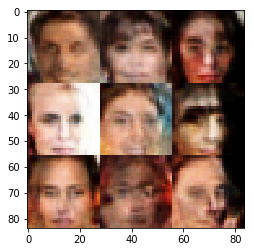

Epoch 1/1... Step 3610  Discriminator Loss: 1.1508... Generator Loss: 0.7719
Epoch 1/1... Step 3620  Discriminator Loss: 1.1622... Generator Loss: 0.7373
Epoch 1/1... Step 3630  Discriminator Loss: 1.0891... Generator Loss: 1.0050
Epoch 1/1... Step 3640  Discriminator Loss: 1.4650... Generator Loss: 1.5967
Epoch 1/1... Step 3650  Discriminator Loss: 1.1642... Generator Loss: 0.6138
Epoch 1/1... Step 3660  Discriminator Loss: 1.5785... Generator Loss: 0.3821
Epoch 1/1... Step 3670  Discriminator Loss: 1.4047... Generator Loss: 0.6593
Epoch 1/1... Step 3680  Discriminator Loss: 1.1779... Generator Loss: 0.6049
Epoch 1/1... Step 3690  Discriminator Loss: 1.0136... Generator Loss: 1.2129
Epoch 1/1... Step 3700  Discriminator Loss: 1.3731... Generator Loss: 0.8074


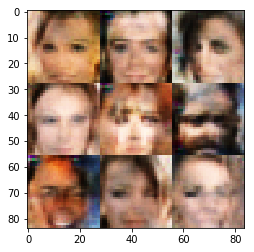

Epoch 1/1... Step 3710  Discriminator Loss: 1.2608... Generator Loss: 0.6775
Epoch 1/1... Step 3720  Discriminator Loss: 1.2419... Generator Loss: 0.8026
Epoch 1/1... Step 3730  Discriminator Loss: 1.3286... Generator Loss: 1.1777
Epoch 1/1... Step 3740  Discriminator Loss: 1.2490... Generator Loss: 1.5675
Epoch 1/1... Step 3750  Discriminator Loss: 1.1482... Generator Loss: 0.8599
Epoch 1/1... Step 3760  Discriminator Loss: 1.2805... Generator Loss: 0.7376
Epoch 1/1... Step 3770  Discriminator Loss: 1.5352... Generator Loss: 0.4098
Epoch 1/1... Step 3780  Discriminator Loss: 1.4856... Generator Loss: 0.4910
Epoch 1/1... Step 3790  Discriminator Loss: 1.1810... Generator Loss: 1.0103
Epoch 1/1... Step 3800  Discriminator Loss: 1.0570... Generator Loss: 1.2809


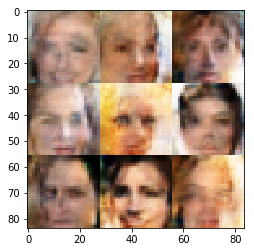

Epoch 1/1... Step 3810  Discriminator Loss: 1.6161... Generator Loss: 1.9693
Epoch 1/1... Step 3820  Discriminator Loss: 1.4274... Generator Loss: 0.5840
Epoch 1/1... Step 3830  Discriminator Loss: 1.2655... Generator Loss: 0.9480
Epoch 1/1... Step 3840  Discriminator Loss: 1.5574... Generator Loss: 1.0519
Epoch 1/1... Step 3850  Discriminator Loss: 1.3282... Generator Loss: 1.1787
Epoch 1/1... Step 3860  Discriminator Loss: 1.3354... Generator Loss: 0.6633
Epoch 1/1... Step 3870  Discriminator Loss: 1.0372... Generator Loss: 0.8181
Epoch 1/1... Step 3880  Discriminator Loss: 2.2759... Generator Loss: 2.3354
Epoch 1/1... Step 3890  Discriminator Loss: 1.2941... Generator Loss: 0.8293
Epoch 1/1... Step 3900  Discriminator Loss: 1.2918... Generator Loss: 0.7235


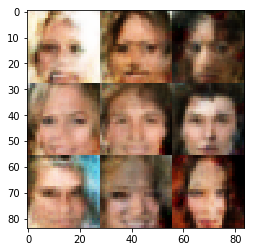

Epoch 1/1... Step 3910  Discriminator Loss: 1.3193... Generator Loss: 0.9935
Epoch 1/1... Step 3920  Discriminator Loss: 1.0327... Generator Loss: 0.8681
Epoch 1/1... Step 3930  Discriminator Loss: 1.5263... Generator Loss: 0.3921
Epoch 1/1... Step 3940  Discriminator Loss: 1.3008... Generator Loss: 0.6531
Epoch 1/1... Step 3950  Discriminator Loss: 1.2689... Generator Loss: 0.8192
Epoch 1/1... Step 3960  Discriminator Loss: 1.1576... Generator Loss: 0.6753
Epoch 1/1... Step 3970  Discriminator Loss: 1.6043... Generator Loss: 0.3818
Epoch 1/1... Step 3980  Discriminator Loss: 1.3998... Generator Loss: 0.7547
Epoch 1/1... Step 3990  Discriminator Loss: 1.2090... Generator Loss: 0.6308
Epoch 1/1... Step 4000  Discriminator Loss: 1.3604... Generator Loss: 0.4940


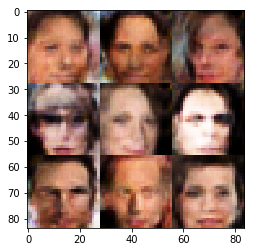

Epoch 1/1... Step 4010  Discriminator Loss: 1.2084... Generator Loss: 0.7226
Epoch 1/1... Step 4020  Discriminator Loss: 1.3332... Generator Loss: 0.8628
Epoch 1/1... Step 4030  Discriminator Loss: 1.1468... Generator Loss: 0.7166
Epoch 1/1... Step 4040  Discriminator Loss: 1.2036... Generator Loss: 0.7973
Epoch 1/1... Step 4050  Discriminator Loss: 1.2024... Generator Loss: 0.8061
Epoch 1/1... Step 4060  Discriminator Loss: 1.6259... Generator Loss: 1.5211
Epoch 1/1... Step 4070  Discriminator Loss: 1.2940... Generator Loss: 0.6224
Epoch 1/1... Step 4080  Discriminator Loss: 1.3124... Generator Loss: 0.9728
Epoch 1/1... Step 4090  Discriminator Loss: 1.5311... Generator Loss: 0.5021
Epoch 1/1... Step 4100  Discriminator Loss: 1.6173... Generator Loss: 0.3522


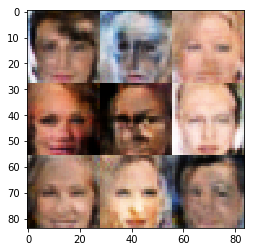

Epoch 1/1... Step 4110  Discriminator Loss: 1.4273... Generator Loss: 0.8352
Epoch 1/1... Step 4120  Discriminator Loss: 1.1345... Generator Loss: 0.6792
Epoch 1/1... Step 4130  Discriminator Loss: 1.4009... Generator Loss: 0.6202
Epoch 1/1... Step 4140  Discriminator Loss: 1.1967... Generator Loss: 1.0028
Epoch 1/1... Step 4150  Discriminator Loss: 1.0570... Generator Loss: 1.0414
Epoch 1/1... Step 4160  Discriminator Loss: 1.6545... Generator Loss: 0.3591
Epoch 1/1... Step 4170  Discriminator Loss: 1.3038... Generator Loss: 0.7835
Epoch 1/1... Step 4180  Discriminator Loss: 1.4272... Generator Loss: 0.8071
Epoch 1/1... Step 4190  Discriminator Loss: 1.7248... Generator Loss: 0.9420
Epoch 1/1... Step 4200  Discriminator Loss: 1.2794... Generator Loss: 0.6607


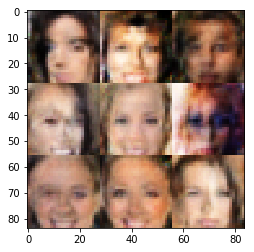

Epoch 1/1... Step 4210  Discriminator Loss: 0.9074... Generator Loss: 0.9856
Epoch 1/1... Step 4220  Discriminator Loss: 1.1561... Generator Loss: 0.9506
Epoch 1/1... Step 4230  Discriminator Loss: 1.3209... Generator Loss: 0.6740
Epoch 1/1... Step 4240  Discriminator Loss: 1.3726... Generator Loss: 0.8673
Epoch 1/1... Step 4250  Discriminator Loss: 1.3684... Generator Loss: 0.7274
Epoch 1/1... Step 4260  Discriminator Loss: 1.3684... Generator Loss: 0.5744
Epoch 1/1... Step 4270  Discriminator Loss: 1.2113... Generator Loss: 0.8248
Epoch 1/1... Step 4280  Discriminator Loss: 1.3218... Generator Loss: 0.7655
Epoch 1/1... Step 4290  Discriminator Loss: 1.3024... Generator Loss: 0.6231
Epoch 1/1... Step 4300  Discriminator Loss: 1.2723... Generator Loss: 0.8597


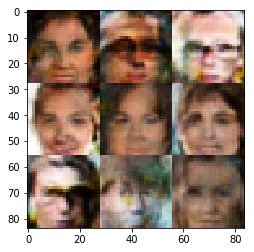

Epoch 1/1... Step 4310  Discriminator Loss: 1.6571... Generator Loss: 0.3645
Epoch 1/1... Step 4320  Discriminator Loss: 1.2595... Generator Loss: 0.5587
Epoch 1/1... Step 4330  Discriminator Loss: 0.9127... Generator Loss: 1.0355
Epoch 1/1... Step 4340  Discriminator Loss: 1.3410... Generator Loss: 0.6730
Epoch 1/1... Step 4350  Discriminator Loss: 1.3785... Generator Loss: 0.5777
Epoch 1/1... Step 4360  Discriminator Loss: 1.4081... Generator Loss: 0.6097
Epoch 1/1... Step 4370  Discriminator Loss: 1.3785... Generator Loss: 0.6516
Epoch 1/1... Step 4380  Discriminator Loss: 1.2804... Generator Loss: 1.1024
Epoch 1/1... Step 4390  Discriminator Loss: 1.0882... Generator Loss: 1.1547
Epoch 1/1... Step 4400  Discriminator Loss: 1.2726... Generator Loss: 0.9568


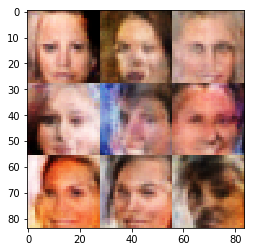

Epoch 1/1... Step 4410  Discriminator Loss: 1.2957... Generator Loss: 0.6021
Epoch 1/1... Step 4420  Discriminator Loss: 1.2498... Generator Loss: 0.7722
Epoch 1/1... Step 4430  Discriminator Loss: 1.1354... Generator Loss: 0.6985
Epoch 1/1... Step 4440  Discriminator Loss: 1.2196... Generator Loss: 0.7198
Epoch 1/1... Step 4450  Discriminator Loss: 1.3504... Generator Loss: 0.6475
Epoch 1/1... Step 4460  Discriminator Loss: 1.3538... Generator Loss: 0.7730
Epoch 1/1... Step 4470  Discriminator Loss: 1.4331... Generator Loss: 1.6140
Epoch 1/1... Step 4480  Discriminator Loss: 1.5365... Generator Loss: 0.4331
Epoch 1/1... Step 4490  Discriminator Loss: 1.2774... Generator Loss: 1.0623
Epoch 1/1... Step 4500  Discriminator Loss: 1.2225... Generator Loss: 0.6539


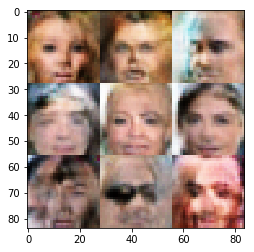

Epoch 1/1... Step 4510  Discriminator Loss: 1.1357... Generator Loss: 1.5461
Epoch 1/1... Step 4520  Discriminator Loss: 1.3401... Generator Loss: 0.5925
Epoch 1/1... Step 4530  Discriminator Loss: 1.1534... Generator Loss: 0.6948
Epoch 1/1... Step 4540  Discriminator Loss: 1.2197... Generator Loss: 0.6876
Epoch 1/1... Step 4550  Discriminator Loss: 1.3487... Generator Loss: 0.5762
Epoch 1/1... Step 4560  Discriminator Loss: 1.3413... Generator Loss: 1.1543
Epoch 1/1... Step 4570  Discriminator Loss: 1.3172... Generator Loss: 0.6377
Epoch 1/1... Step 4580  Discriminator Loss: 1.3982... Generator Loss: 0.6043
Epoch 1/1... Step 4590  Discriminator Loss: 1.3755... Generator Loss: 1.2896
Epoch 1/1... Step 4600  Discriminator Loss: 1.3920... Generator Loss: 0.7281


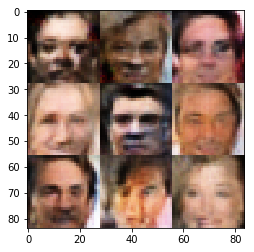

Epoch 1/1... Step 4610  Discriminator Loss: 1.3337... Generator Loss: 0.6802
Epoch 1/1... Step 4620  Discriminator Loss: 1.0904... Generator Loss: 0.8516
Epoch 1/1... Step 4630  Discriminator Loss: 1.2153... Generator Loss: 1.0708
Epoch 1/1... Step 4640  Discriminator Loss: 1.1935... Generator Loss: 0.9675
Epoch 1/1... Step 4650  Discriminator Loss: 1.3578... Generator Loss: 0.9668
Epoch 1/1... Step 4660  Discriminator Loss: 1.2695... Generator Loss: 0.6121
Epoch 1/1... Step 4670  Discriminator Loss: 1.1195... Generator Loss: 1.3706
Epoch 1/1... Step 4680  Discriminator Loss: 1.2988... Generator Loss: 0.6235
Epoch 1/1... Step 4690  Discriminator Loss: 1.0439... Generator Loss: 1.4166
Epoch 1/1... Step 4700  Discriminator Loss: 1.2734... Generator Loss: 1.1773


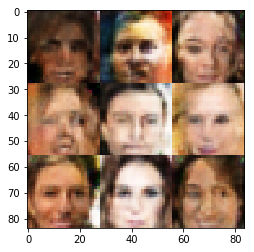

Epoch 1/1... Step 4710  Discriminator Loss: 1.2831... Generator Loss: 0.7600
Epoch 1/1... Step 4720  Discriminator Loss: 1.1285... Generator Loss: 0.7395
Epoch 1/1... Step 4730  Discriminator Loss: 1.1141... Generator Loss: 0.8040
Epoch 1/1... Step 4740  Discriminator Loss: 1.3309... Generator Loss: 0.5573
Epoch 1/1... Step 4750  Discriminator Loss: 1.0658... Generator Loss: 0.8154
Epoch 1/1... Step 4760  Discriminator Loss: 1.4115... Generator Loss: 0.8768
Epoch 1/1... Step 4770  Discriminator Loss: 1.3008... Generator Loss: 0.6674
Epoch 1/1... Step 4780  Discriminator Loss: 1.5211... Generator Loss: 0.9047
Epoch 1/1... Step 4790  Discriminator Loss: 1.3889... Generator Loss: 0.6559
Epoch 1/1... Step 4800  Discriminator Loss: 1.5175... Generator Loss: 0.5297


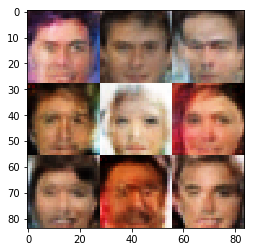

Epoch 1/1... Step 4810  Discriminator Loss: 1.4758... Generator Loss: 0.6093
Epoch 1/1... Step 4820  Discriminator Loss: 1.3158... Generator Loss: 1.1246
Epoch 1/1... Step 4830  Discriminator Loss: 1.1349... Generator Loss: 0.8890
Epoch 1/1... Step 4840  Discriminator Loss: 1.8264... Generator Loss: 1.4987
Epoch 1/1... Step 4850  Discriminator Loss: 1.2817... Generator Loss: 1.3021
Epoch 1/1... Step 4860  Discriminator Loss: 1.4198... Generator Loss: 0.5524
Epoch 1/1... Step 4870  Discriminator Loss: 1.3701... Generator Loss: 0.8946
Epoch 1/1... Step 4880  Discriminator Loss: 1.3933... Generator Loss: 0.6671
Epoch 1/1... Step 4890  Discriminator Loss: 1.3957... Generator Loss: 0.4808
Epoch 1/1... Step 4900  Discriminator Loss: 1.3729... Generator Loss: 0.7065


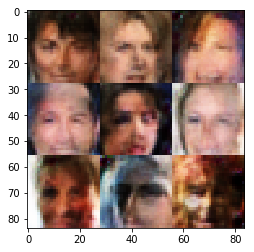

Epoch 1/1... Step 4910  Discriminator Loss: 1.2160... Generator Loss: 0.9005
Epoch 1/1... Step 4920  Discriminator Loss: 1.3480... Generator Loss: 0.9705
Epoch 1/1... Step 4930  Discriminator Loss: 1.2526... Generator Loss: 0.6086
Epoch 1/1... Step 4940  Discriminator Loss: 1.3106... Generator Loss: 0.7106
Epoch 1/1... Step 4950  Discriminator Loss: 1.3181... Generator Loss: 0.8837
Epoch 1/1... Step 4960  Discriminator Loss: 1.3187... Generator Loss: 0.5686
Epoch 1/1... Step 4970  Discriminator Loss: 1.3162... Generator Loss: 1.2635
Epoch 1/1... Step 4980  Discriminator Loss: 1.3225... Generator Loss: 0.6491
Epoch 1/1... Step 4990  Discriminator Loss: 1.2471... Generator Loss: 0.9155
Epoch 1/1... Step 5000  Discriminator Loss: 1.0029... Generator Loss: 0.9939


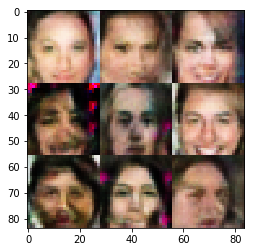

Epoch 1/1... Step 5010  Discriminator Loss: 1.3505... Generator Loss: 0.7476
Epoch 1/1... Step 5020  Discriminator Loss: 1.5263... Generator Loss: 0.4839
Epoch 1/1... Step 5030  Discriminator Loss: 1.2144... Generator Loss: 0.7968
Epoch 1/1... Step 5040  Discriminator Loss: 1.4534... Generator Loss: 0.5617
Epoch 1/1... Step 5050  Discriminator Loss: 1.4123... Generator Loss: 0.5584
Epoch 1/1... Step 5060  Discriminator Loss: 1.2350... Generator Loss: 0.8154
Epoch 1/1... Step 5070  Discriminator Loss: 1.1654... Generator Loss: 0.6717
Epoch 1/1... Step 5080  Discriminator Loss: 1.2805... Generator Loss: 0.8699
Epoch 1/1... Step 5090  Discriminator Loss: 1.3026... Generator Loss: 0.6796
Epoch 1/1... Step 5100  Discriminator Loss: 1.3682... Generator Loss: 0.6476


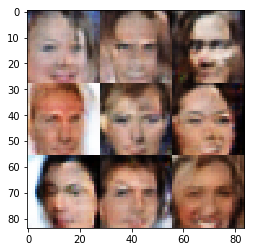

Epoch 1/1... Step 5110  Discriminator Loss: 1.1200... Generator Loss: 1.0456
Epoch 1/1... Step 5120  Discriminator Loss: 1.4205... Generator Loss: 0.6240
Epoch 1/1... Step 5130  Discriminator Loss: 1.4947... Generator Loss: 0.9236
Epoch 1/1... Step 5140  Discriminator Loss: 1.5072... Generator Loss: 0.4739
Epoch 1/1... Step 5150  Discriminator Loss: 1.2577... Generator Loss: 1.0573
Epoch 1/1... Step 5160  Discriminator Loss: 1.2594... Generator Loss: 1.1600
Epoch 1/1... Step 5170  Discriminator Loss: 0.8909... Generator Loss: 1.2170
Epoch 1/1... Step 5180  Discriminator Loss: 1.4055... Generator Loss: 0.5114
Epoch 1/1... Step 5190  Discriminator Loss: 1.3089... Generator Loss: 0.9618
Epoch 1/1... Step 5200  Discriminator Loss: 1.2308... Generator Loss: 0.8491


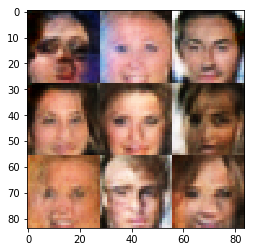

Epoch 1/1... Step 5210  Discriminator Loss: 1.1672... Generator Loss: 0.8420
Epoch 1/1... Step 5220  Discriminator Loss: 1.1905... Generator Loss: 0.6892
Epoch 1/1... Step 5230  Discriminator Loss: 1.2454... Generator Loss: 1.1307
Epoch 1/1... Step 5240  Discriminator Loss: 1.2581... Generator Loss: 0.6876
Epoch 1/1... Step 5250  Discriminator Loss: 1.2257... Generator Loss: 0.8461
Epoch 1/1... Step 5260  Discriminator Loss: 1.3341... Generator Loss: 0.7185
Epoch 1/1... Step 5270  Discriminator Loss: 1.1145... Generator Loss: 0.6869
Epoch 1/1... Step 5280  Discriminator Loss: 1.1676... Generator Loss: 0.9611
Epoch 1/1... Step 5290  Discriminator Loss: 1.3060... Generator Loss: 0.6824
Epoch 1/1... Step 5300  Discriminator Loss: 1.3624... Generator Loss: 0.7093


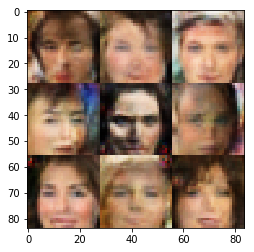

Epoch 1/1... Step 5310  Discriminator Loss: 0.9796... Generator Loss: 1.0081
Epoch 1/1... Step 5320  Discriminator Loss: 1.1737... Generator Loss: 0.8604
Epoch 1/1... Step 5330  Discriminator Loss: 1.1747... Generator Loss: 0.8596
Epoch 1/1... Step 5340  Discriminator Loss: 1.0990... Generator Loss: 0.8509
Epoch 1/1... Step 5350  Discriminator Loss: 1.2589... Generator Loss: 0.7652
Epoch 1/1... Step 5360  Discriminator Loss: 1.2788... Generator Loss: 0.6551
Epoch 1/1... Step 5370  Discriminator Loss: 1.4604... Generator Loss: 0.8171
Epoch 1/1... Step 5380  Discriminator Loss: 1.0486... Generator Loss: 1.4071
Epoch 1/1... Step 5390  Discriminator Loss: 1.0251... Generator Loss: 1.2420
Epoch 1/1... Step 5400  Discriminator Loss: 1.4889... Generator Loss: 1.3704


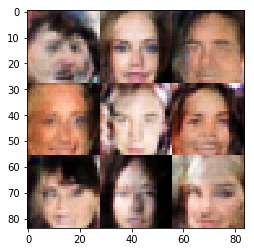

Epoch 1/1... Step 5410  Discriminator Loss: 1.3772... Generator Loss: 0.6149
Epoch 1/1... Step 5420  Discriminator Loss: 1.4555... Generator Loss: 0.4307
Epoch 1/1... Step 5430  Discriminator Loss: 1.5399... Generator Loss: 0.4137
Epoch 1/1... Step 5440  Discriminator Loss: 1.3998... Generator Loss: 0.5831
Epoch 1/1... Step 5450  Discriminator Loss: 1.3266... Generator Loss: 0.6732
Epoch 1/1... Step 5460  Discriminator Loss: 1.1939... Generator Loss: 0.8362
Epoch 1/1... Step 5470  Discriminator Loss: 1.3186... Generator Loss: 0.6566
Epoch 1/1... Step 5480  Discriminator Loss: 1.3204... Generator Loss: 0.7039
Epoch 1/1... Step 5490  Discriminator Loss: 1.3146... Generator Loss: 0.6433
Epoch 1/1... Step 5500  Discriminator Loss: 1.2458... Generator Loss: 0.7346


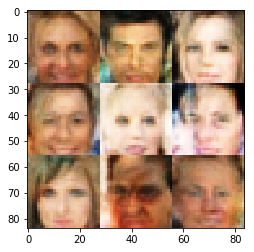

Epoch 1/1... Step 5510  Discriminator Loss: 1.4161... Generator Loss: 0.7928
Epoch 1/1... Step 5520  Discriminator Loss: 1.5046... Generator Loss: 0.4732
Epoch 1/1... Step 5530  Discriminator Loss: 1.3079... Generator Loss: 0.8169
Epoch 1/1... Step 5540  Discriminator Loss: 1.3076... Generator Loss: 0.6016
Epoch 1/1... Step 5550  Discriminator Loss: 1.5043... Generator Loss: 0.5027
Epoch 1/1... Step 5560  Discriminator Loss: 1.4996... Generator Loss: 0.4144
Epoch 1/1... Step 5570  Discriminator Loss: 1.2977... Generator Loss: 0.8619
Epoch 1/1... Step 5580  Discriminator Loss: 1.3809... Generator Loss: 0.6955
Epoch 1/1... Step 5590  Discriminator Loss: 1.3758... Generator Loss: 0.8037
Epoch 1/1... Step 5600  Discriminator Loss: 1.2657... Generator Loss: 0.6817


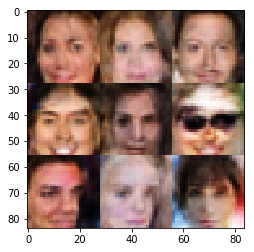

Epoch 1/1... Step 5610  Discriminator Loss: 1.3253... Generator Loss: 0.7749
Epoch 1/1... Step 5620  Discriminator Loss: 1.5043... Generator Loss: 0.6905
Epoch 1/1... Step 5630  Discriminator Loss: 1.1515... Generator Loss: 0.8068
Epoch 1/1... Step 5640  Discriminator Loss: 1.3379... Generator Loss: 0.6255
Epoch 1/1... Step 5650  Discriminator Loss: 1.2108... Generator Loss: 0.7844
Epoch 1/1... Step 5660  Discriminator Loss: 1.3052... Generator Loss: 0.6702
Epoch 1/1... Step 5670  Discriminator Loss: 1.3011... Generator Loss: 0.7009
Epoch 1/1... Step 5680  Discriminator Loss: 1.3558... Generator Loss: 0.6535
Epoch 1/1... Step 5690  Discriminator Loss: 1.3826... Generator Loss: 0.7264
Epoch 1/1... Step 5700  Discriminator Loss: 1.4169... Generator Loss: 0.4815


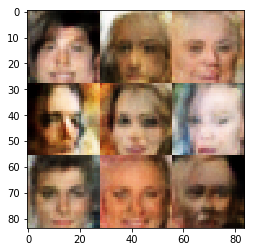

Epoch 1/1... Step 5710  Discriminator Loss: 1.3809... Generator Loss: 0.6024
Epoch 1/1... Step 5720  Discriminator Loss: 1.2857... Generator Loss: 0.7454
Epoch 1/1... Step 5730  Discriminator Loss: 1.3171... Generator Loss: 0.7428
Epoch 1/1... Step 5740  Discriminator Loss: 1.2463... Generator Loss: 0.7862
Epoch 1/1... Step 5750  Discriminator Loss: 1.1822... Generator Loss: 0.8962
Epoch 1/1... Step 5760  Discriminator Loss: 1.4692... Generator Loss: 0.5583
Epoch 1/1... Step 5770  Discriminator Loss: 1.3335... Generator Loss: 0.6763
Epoch 1/1... Step 5780  Discriminator Loss: 1.3511... Generator Loss: 0.6409
Epoch 1/1... Step 5790  Discriminator Loss: 1.3675... Generator Loss: 0.6184
Epoch 1/1... Step 5800  Discriminator Loss: 1.4299... Generator Loss: 0.6359


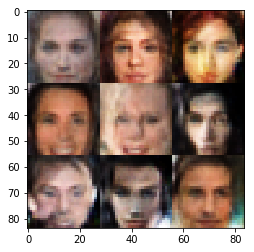

Epoch 1/1... Step 5810  Discriminator Loss: 1.2329... Generator Loss: 0.8294
Epoch 1/1... Step 5820  Discriminator Loss: 1.2463... Generator Loss: 0.8007
Epoch 1/1... Step 5830  Discriminator Loss: 1.2197... Generator Loss: 0.7871
Epoch 1/1... Step 5840  Discriminator Loss: 1.3452... Generator Loss: 0.7616
Epoch 1/1... Step 5850  Discriminator Loss: 1.1433... Generator Loss: 1.0040
Epoch 1/1... Step 5860  Discriminator Loss: 1.3498... Generator Loss: 0.5890
Epoch 1/1... Step 5870  Discriminator Loss: 1.3938... Generator Loss: 0.8822
Epoch 1/1... Step 5880  Discriminator Loss: 1.2979... Generator Loss: 0.6689
Epoch 1/1... Step 5890  Discriminator Loss: 0.8494... Generator Loss: 1.1151
Epoch 1/1... Step 5900  Discriminator Loss: 1.2915... Generator Loss: 0.6282


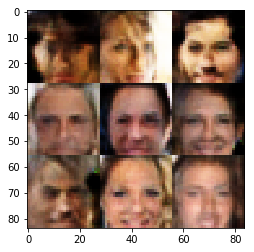

Epoch 1/1... Step 5910  Discriminator Loss: 1.4418... Generator Loss: 0.6082
Epoch 1/1... Step 5920  Discriminator Loss: 1.2800... Generator Loss: 1.2343
Epoch 1/1... Step 5930  Discriminator Loss: 1.4430... Generator Loss: 0.7325
Epoch 1/1... Step 5940  Discriminator Loss: 1.1194... Generator Loss: 0.9043
Epoch 1/1... Step 5950  Discriminator Loss: 1.2821... Generator Loss: 0.9902
Epoch 1/1... Step 5960  Discriminator Loss: 1.2895... Generator Loss: 0.9157
Epoch 1/1... Step 5970  Discriminator Loss: 1.2023... Generator Loss: 0.9339
Epoch 1/1... Step 5980  Discriminator Loss: 1.5023... Generator Loss: 0.5281
Epoch 1/1... Step 5990  Discriminator Loss: 1.2685... Generator Loss: 0.7886
Epoch 1/1... Step 6000  Discriminator Loss: 1.3743... Generator Loss: 0.7859


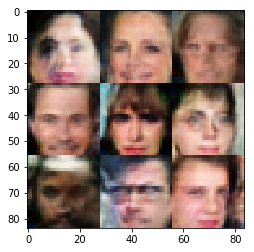

Epoch 1/1... Step 6010  Discriminator Loss: 1.2482... Generator Loss: 0.7675
Epoch 1/1... Step 6020  Discriminator Loss: 1.3335... Generator Loss: 0.6933
Epoch 1/1... Step 6030  Discriminator Loss: 1.0370... Generator Loss: 0.9654
Epoch 1/1... Step 6040  Discriminator Loss: 1.2891... Generator Loss: 0.8275
Epoch 1/1... Step 6050  Discriminator Loss: 1.1720... Generator Loss: 0.7142
Epoch 1/1... Step 6060  Discriminator Loss: 1.2266... Generator Loss: 0.8747
Epoch 1/1... Step 6070  Discriminator Loss: 1.2205... Generator Loss: 0.9224
Epoch 1/1... Step 6080  Discriminator Loss: 1.3277... Generator Loss: 0.8360
Epoch 1/1... Step 6090  Discriminator Loss: 1.2384... Generator Loss: 0.8842
Epoch 1/1... Step 6100  Discriminator Loss: 1.2638... Generator Loss: 0.7901


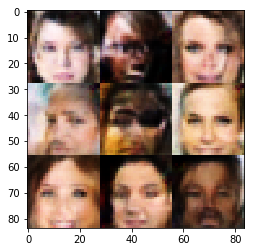

Epoch 1/1... Step 6110  Discriminator Loss: 1.3857... Generator Loss: 0.7461
Epoch 1/1... Step 6120  Discriminator Loss: 1.0866... Generator Loss: 1.0664
Epoch 1/1... Step 6130  Discriminator Loss: 1.2191... Generator Loss: 0.7641
Epoch 1/1... Step 6140  Discriminator Loss: 1.4007... Generator Loss: 0.4918
Epoch 1/1... Step 6150  Discriminator Loss: 1.3822... Generator Loss: 0.6626
Epoch 1/1... Step 6160  Discriminator Loss: 1.1947... Generator Loss: 1.0416
Epoch 1/1... Step 6170  Discriminator Loss: 1.3767... Generator Loss: 0.6409
Epoch 1/1... Step 6180  Discriminator Loss: 1.3075... Generator Loss: 0.7751
Epoch 1/1... Step 6190  Discriminator Loss: 1.2856... Generator Loss: 0.8852
Epoch 1/1... Step 6200  Discriminator Loss: 1.3033... Generator Loss: 0.6351


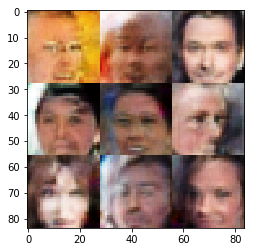

Epoch 1/1... Step 6210  Discriminator Loss: 1.3103... Generator Loss: 0.6925
Epoch 1/1... Step 6220  Discriminator Loss: 1.3790... Generator Loss: 0.6431
Epoch 1/1... Step 6230  Discriminator Loss: 1.1641... Generator Loss: 0.8744
Epoch 1/1... Step 6240  Discriminator Loss: 1.4314... Generator Loss: 0.7090
Epoch 1/1... Step 6250  Discriminator Loss: 1.3947... Generator Loss: 0.6040
Epoch 1/1... Step 6260  Discriminator Loss: 1.1210... Generator Loss: 0.8556
Epoch 1/1... Step 6270  Discriminator Loss: 1.2995... Generator Loss: 0.8339
Epoch 1/1... Step 6280  Discriminator Loss: 1.3122... Generator Loss: 0.8061
Epoch 1/1... Step 6290  Discriminator Loss: 1.4850... Generator Loss: 0.4860
Epoch 1/1... Step 6300  Discriminator Loss: 1.3334... Generator Loss: 0.7261


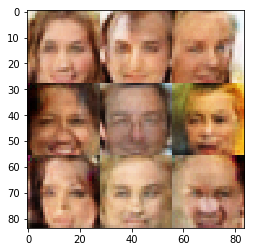

Epoch 1/1... Step 6310  Discriminator Loss: 1.3051... Generator Loss: 0.8716
Epoch 1/1... Step 6320  Discriminator Loss: 1.3711... Generator Loss: 0.7545
Epoch 1/1... Step 6330  Discriminator Loss: 1.2710... Generator Loss: 1.1087


In [42]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [43]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
celeba_dataset.shape

(202599, 28, 28, 3)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.